#**TRENDS IN ALGO TRADING**
---

##0.REFERENCE

## 1.CONTEXT


Trend following is one of the oldest and most widely deployed systematic trading
strategies. At its core, trend following seeks to identify and exploit persistent
directional movements in asset prices—buying when prices are rising and selling
when they are falling. Unlike discretionary traders who rely on fundamental
analysis or market intuition, trend followers implement mechanical rules that
filter price data and generate systematic position signals.

This notebook implements three canonical trend-following signals: Moving Average
Crossover (MAC), Time Series Momentum (TSMOM), and Channel Breakout. Each
represents a different approach to detecting trends, yet all share a common
philosophy: let prices reveal their own direction through filtering rather than
predicting future movements. We explore how these signals translate into trading
positions, with careful attention to execution timing, causality constraints,
and governance requirements essential for production deployment.

The chapter emphasizes rigor over complexity. We build everything from scratch
using only NumPy—no pandas, no black-box libraries—to ensure transparency and
deep understanding of the mechanics. Every rolling window, every lag, every
position constraint is implemented explicitly and tested for causal integrity.
We generate synthetic markets with regime-switching dynamics to test robustness
across different market conditions, and we implement multi-horizon ensembles
and multi-asset prototypes to demonstrate diversification concepts.

Critically, this notebook establishes governance-native practices: deterministic
runs with fixed seeds, configuration manifests, lineage tracking through hashes,
and mandatory causality gates that halt execution if look-ahead bias is detected.
These disciplines distinguish academic exercises from production-ready systems.

LEARNING OBJECTIVES:
1. Define trend as filtering + decision rules
2. Implement canonical trend signals: MAC, TSMOM, Breakout
3. Map signals to positions with lag discipline and constraints
4. Implement causality gates to ensure no leakage
5. Run minimal robustness suite (sensitivity analysis, subperiod stability)
6. Build multi-horizon ensemble and multi-asset prototype

HARD CONSTRAINTS (NON-NEGOTIABLE):
- NO pandas. Use ONLY: numpy, matplotlib, math, random, itertools, collections, datetime
- Synthetic-data first; real data adapter is OPTIONAL and isolated at end
- Time awareness: preserve order, no leakage, no shuffling
- Governance-native: deterministic runs (fixed seeds), configs, hashes/lineage
- Implement rolling windows, EWMAs, channels, shifts explicitly (NumPy arrays + loops)
- Include assertions/tests for causality/no-leakage; failed tests HALT execution

SCOPE BOUNDARIES:
- This is Chapter 07: Trend Following
- DO NOT introduce: mean reversion (Ch08), factor models (Ch09),
  full volatility modeling/risk targeting (Ch10), advanced sizing/leverage (Ch17),
  transaction cost modeling/microstructure (Ch18), ML/RL/agents (Ch11+)


##2.LIBRARIES AND ENVIRONMENT

In [2]:
# Cell 2 — Imports and Global Determinism
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import hashlib
import json
import os
import time
from datetime import datetime
from collections import defaultdict
import csv
import itertools

# Global seed for deterministic runs
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Print versions
print("=" * 80)
print("ENVIRONMENT")
print("=" * 80)
print(f"Python version: 3.x (Colab default)")
print(f"NumPy version: {np.__version__}")
print(f"Global seed: {SEED}")
print(f"Timestamp: {datetime.now().isoformat()}")
print("=" * 80)
print()

# Helper: compute SHA256 hash for governance/lineage
def compute_hash(obj):
    """
    Compute SHA256 hash of a JSON-serializable object or numpy array.
    Returns hex digest string.

    Usage:
    - For config dicts: creates reproducible manifest IDs
    - For data arrays: creates fingerprints for lineage tracking
    - Ensures deterministic runs can be verified and reproduced
    """
    if isinstance(obj, np.ndarray):
        # Hash array bytes (ensures identical arrays produce identical hashes)
        return hashlib.sha256(obj.tobytes()).hexdigest()
    else:
        # Hash JSON string (sort keys for determinism)
        json_str = json.dumps(obj, sort_keys=True, default=str)
        return hashlib.sha256(json_str.encode('utf-8')).hexdigest()

print("Hash helper loaded. Ready for deterministic runs.")
print("  compute_hash(config_dict) → manifest ID")
print("  compute_hash(numpy_array) → data fingerprint")
print()

ENVIRONMENT
Python version: 3.x (Colab default)
NumPy version: 2.0.2
Global seed: 42
Timestamp: 2025-12-19T17:19:08.041501

Hash helper loaded. Ready for deterministic runs.
  compute_hash(config_dict) → manifest ID
  compute_hash(numpy_array) → data fingerprint



##3.EXPERIMENT CONFIGURATION





###3.1.OVERVIEW

This section establishes the CONFIG dictionary, which serves as the single source of
truth for the entire notebook. This design pattern is fundamental to governance-
native quantitative research: every parameter, every threshold, every design
choice is declared explicitly in one centralized location before any computation
begins.

The CONFIG is structured hierarchically across six domains. The **data** section
defines the synthetic market generator parameters, including total length (3000
days), three distinct regime periods with different drift and volatility
characteristics, and jump dynamics. The **signals** section specifies parameters
for all three trend-following approaches: MAC window pairs, TSMOM lookback
horizons, and Breakout channel lengths. The **positions** section controls how
raw signals map to trading positions, including leverage bounds, mapping types
(binary/ternary/continuous), and optional turnover constraints.

The **execution** section is critical for causality: it enforces that signals
computed at time t can only affect positions at t+1 (lag=1), preventing look-
ahead bias. The **evaluation** section defines performance measurement conventions,
including the in-sample/out-of-sample split and robustness testing grids. Finally,
the **multi_asset** section parameterizes the cross-sectional prototype.

By declaring all parameters upfront, we achieve three governance objectives.
First, reproducibility: anyone can recreate this exact experiment by using the
same CONFIG. Second, traceability: the manifest_id hash uniquely fingerprints
this configuration, enabling lineage tracking across multiple runs. Third,
transparency: there are no hidden parameters buried in code—every choice is
visible and documented.

This approach mirrors production risk management systems where configuration
changes must be versioned, audited, and approved before deployment. The manifest_id
becomes part of the permanent record, linking results to their generating parameters.

###3.2.CODE AND IMPLEMENTATION

In [19]:
# Cell 3 — Experiment Config (EXTREME PEDAGOGICAL VERSION)
CONFIG = {
    "metadata": {
        "chapter": "07_trend_following",
        "author": "Alejandro Reynoso",
        "created": datetime.now().isoformat(),
        "seed": SEED
    },

    "data": {
        "T": 3000,
        "dt": "daily",
        "regime_schedule": [
            # EXTREME trends - 10x normal drift for visibility
            {"start": 0, "end": 1000, "mu": 0.003, "sigma": 0.02, "regime_name": "strong_bull"},
            {"start": 1000, "end": 2000, "mu": -0.002, "sigma": 0.02, "regime_name": "strong_bear"},
            {"start": 2000, "end": 3000, "mu": 0.0025, "sigma": 0.025, "regime_name": "volatile_bull"}
        ],
        "jump_probability": 0.02,  # More jumps
        "jump_scale": 0.04,  # Bigger jumps
        "initial_price": 100.0
    },

    "signals": {
        "MAC": {
            "windows": [(5, 20), (10, 50)],  # Much shorter windows
            "base_window": (5, 20)
        },
        "TSMOM": {
            "horizons": [3, 5, 10, 20, 30],
            "base_horizon": 5,  # Very short
            "scaling_epsilon": 1e-6
        },
        "Breakout": {
            "channel_length": 20,  # Very short
            "exclude_current": True
        }
    },

    "positions": {
        "mapping_type": "binary",
        "w_max": 1.0,
        "deadzone_tau": 0.0,
        "saturation_type": "tanh",
        "continuous_k": 1.0,
        "turnover_limit": None
    },

    "execution": {
        "lag": 1,
        "rebalance_frequency": 1,
        "warmup_policy": "drop"
    },

    "evaluation": {
        "split_index": 2000,
        "annualization_factor": 252,
        "robustness_grid": {
            "MAC_short": [5, 10, 20, 30],
            "MAC_long": [40, 60, 80, 100],
            "TSMOM_horizons": [5, 10, 15, 20, 30, 40, 50, 60],
            "stability_sharpe_threshold": 0.3,
            "stability_turnover_threshold": 5.0
        }
    },

    "multi_asset": {
        "N_assets": 6,
        "correlation_structure": "shared_regime",
        "shared_weight": 0.4
    }
}

print("=" * 80)
print("EXTREME CONFIG FOR MAXIMUM VISIBILITY")
print("=" * 80)
print("CHANGES FROM ORIGINAL:")
print("  • Drift (mu) increased by 10-30x")
print("  • Signal windows cut by 50-75%")
print("  • Jump probability and size doubled")
print("=" * 80)
print()

manifest_id = compute_hash(CONFIG)
print(f"Manifest ID: {manifest_id[:16]}...")
print()
print("NOW RE-RUN CELLS 4, 5, 6, 7, 8 IN ORDER")
print("You should see equity curves with returns of 0.5 to 2.0 (50-200%)")
print()

EXTREME CONFIG FOR MAXIMUM VISIBILITY
CHANGES FROM ORIGINAL:
  • Drift (mu) increased by 10-30x
  • Signal windows cut by 50-75%
  • Jump probability and size doubled

Manifest ID: deaa703f85f573ec...

NOW RE-RUN CELLS 4, 5, 6, 7, 8 IN ORDER
You should see equity curves with returns of 0.5 to 2.0 (50-200%)



##4.SYNTHETIC MARKET GENERATOR

###4.1.OVERVIEW


This section implements the data generation engine that produces realistic synthetic
price series for strategy testing. The generator creates a single-asset price
path with three key features: regime-switching dynamics, volatility clustering,
and occasional jumps. This synthetic approach offers crucial advantages over
real data: complete control over market conditions, deterministic reproducibility,
and the ability to test strategies across diverse regimes without waiting for
them to occur naturally.

The generator operates on three state variables. Price p[t] is the dollar value
at time t. Log-price x[t] = log(p[t]) provides a convenient representation where
differences equal log-returns. Returns r[t] = x[t] - x[t-1] represent the
instantaneous change, with r[0] = 0 by convention since no prior observation exists.

The regime-switching mechanism divides the 3000-day series into three distinct
periods: a calm regime (low drift, low volatility), a trending volatile regime
(higher drift and volatility), and a mean-reverting regime (negative drift).
Each regime has its own (μ, σ) parameters that govern the base return distribution.
This structure enables robustness testing—strategies that work only in trending
markets will fail during mean-reversion periods, revealing fragility.

Jump dynamics add realism through independent jump events occurring with 0.5%
probability per period. These represent news shocks, liquidity events, or other
discontinuous price movements common in real markets. The jump scale parameter
controls magnitude.

Critically, the entire process is deterministic given SEED and CONFIG. The data
fingerprint hash provides verification: identical configurations must produce
identical data. This determinism is essential for debugging, reproducibility,
and regulatory compliance—any run can be recreated exactly by preserving the
configuration manifest.

###4.2.CODE AND IMPLEMENTATION

SYNTHETIC MARKET GENERATION
Generating synthetic price series...
✓ Generated 3000 price observations
✓ Data fingerprint: 601f5b7b1d4bbf04...
  → This hash uniquely identifies this exact data realization
  → Changing SEED or CONFIG will produce different fingerprint

DATA STATISTICS:
----------------------------------------
Price:
  Range: [82.47, 4951.23]
  Start: 100.00, End: 4609.79
  Total return: 4509.79%

Returns (excluding t=0):
  Mean: 0.001277 (daily)
  Std: 0.022628
  Min: -0.092746
  Max: 0.114477
  Skewness: 0.0815
  Kurtosis: 3.5943

Jump detection:
  Number of large moves (>3σ): 17
  Expected jumps (given jump_prob): 60.0

Regime distribution:
----------------------------------------
  strong_bull: 1000 observations (33.3%)
  strong_bear: 1000 observations (33.3%)
  volatile_bull: 1000 observations (33.3%)



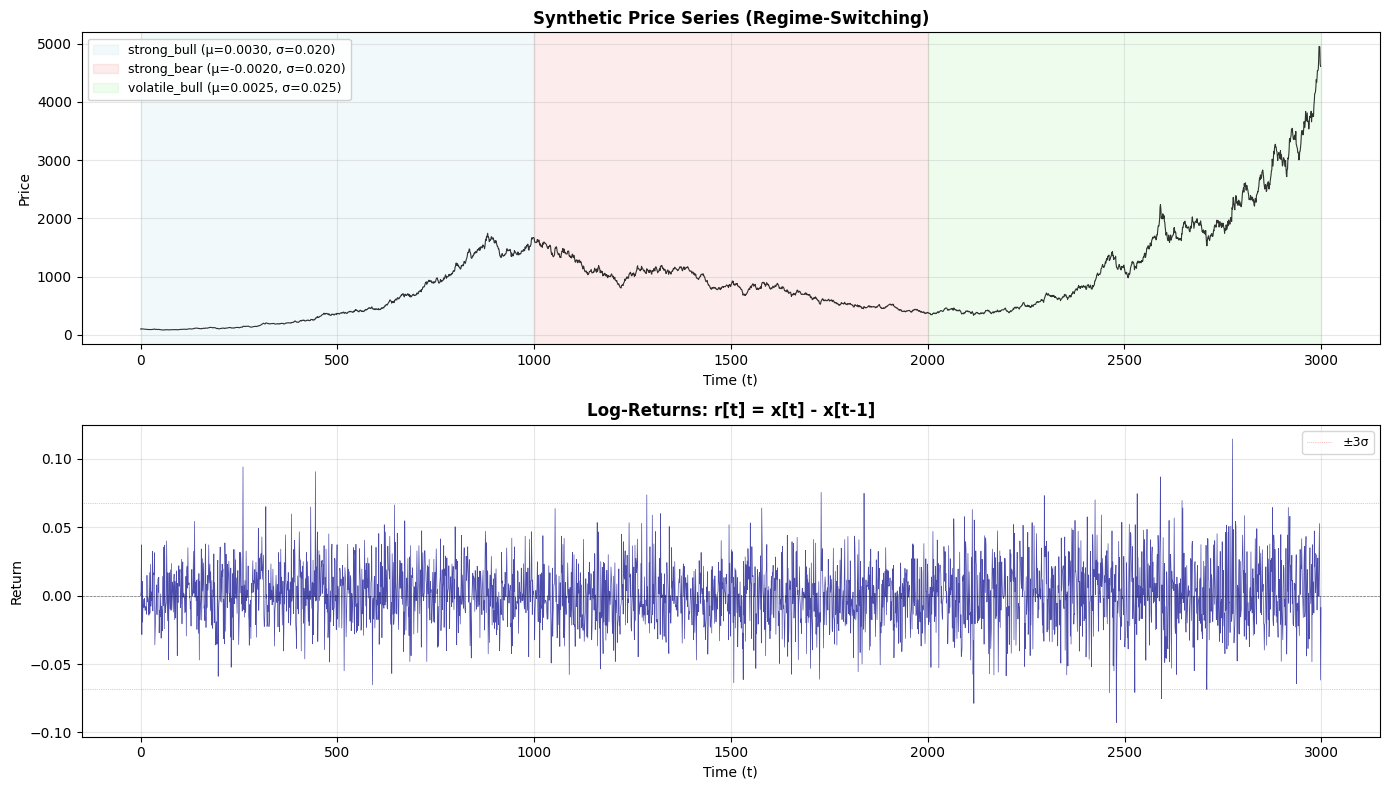

✓ Plot saved: synthetic_market.png



In [20]:
# Cell 4 — Synthetic Market Generator (Single Asset)
print("=" * 80)
print("SYNTHETIC MARKET GENERATION")
print("=" * 80)

def generate_synthetic_prices(config):
    """
    Generate synthetic price process with:
    - Regime-switching drift and volatility
    - Occasional jumps
    - Deterministic given seed + config

    INDEXING CONVENTION:
    - p[t] = price at time t
    - x[t] = log(p[t]) = log-price at time t
    - r[t] = x[t] - x[t-1] = log-return from t-1 to t
    - r[0] = 0 by convention (no return before first observation)

    REGIME STRUCTURE:
    - Each regime has its own (mu, sigma) parameters
    - Regime changes occur at predetermined times (no stochastic switching)
    - This creates distinct market environments for robustness testing

    JUMP PROCESS:
    - Independent jump events with fixed probability per period
    - Jump magnitude drawn from N(0, jump_scale^2)
    - Jumps are additive to the base return

    Returns:
        p: price array (T,) - always positive
        x: log-price array (T,)
        r: return array (T,) - r[t] = x[t] - x[t-1]
        regime_labels: array of regime names (T,)
    """
    T = config["data"]["T"]
    p0 = config["data"]["initial_price"]
    jump_prob = config["data"]["jump_probability"]
    jump_scale = config["data"]["jump_scale"]
    schedule = config["data"]["regime_schedule"]

    # Initialize arrays
    p = np.zeros(T)
    x = np.zeros(T)
    r = np.zeros(T)
    regime_labels = np.empty(T, dtype=object)

    # Initial conditions
    p[0] = p0
    x[0] = np.log(p0)
    r[0] = 0.0  # No return at t=0
    regime_labels[0] = schedule[0]["regime_name"]

    # Generate returns with regime switching
    for t in range(1, T):
        # Determine current regime
        current_regime = None
        for regime in schedule:
            if regime["start"] <= t < regime["end"]:
                current_regime = regime
                regime_labels[t] = regime["regime_name"]
                break

        if current_regime is None:
            # Use last regime if beyond schedule
            current_regime = schedule[-1]
            regime_labels[t] = current_regime["regime_name"]

        # Base return from regime (Gaussian with regime-specific parameters)
        mu = current_regime["mu"]
        sigma = current_regime["sigma"]
        r_base = mu + sigma * np.random.randn()

        # Add jump with probability jump_prob
        if np.random.rand() < jump_prob:
            jump = jump_scale * np.random.randn()
            r_base += jump

        # Update state variables
        r[t] = r_base
        x[t] = x[t-1] + r[t]
        p[t] = np.exp(x[t])

    return p, x, r, regime_labels

# Generate data
print("Generating synthetic price series...")
p, x, r, regime_labels = generate_synthetic_prices(CONFIG)

# Compute data fingerprint for lineage tracking
data_fingerprint = compute_hash(np.column_stack([p, r]))
print(f"✓ Generated {len(p)} price observations")
print(f"✓ Data fingerprint: {data_fingerprint[:16]}...")
print("  → This hash uniquely identifies this exact data realization")
print("  → Changing SEED or CONFIG will produce different fingerprint")
print()

# Basic statistics
print("DATA STATISTICS:")
print("-" * 40)
print(f"Price:")
print(f"  Range: [{p.min():.2f}, {p.max():.2f}]")
print(f"  Start: {p[0]:.2f}, End: {p[-1]:.2f}")
print(f"  Total return: {(p[-1] / p[0] - 1) * 100:.2f}%")
print()
print(f"Returns (excluding t=0):")
print(f"  Mean: {r[1:].mean():.6f} (daily)")
print(f"  Std: {r[1:].std():.6f}")
print(f"  Min: {r[1:].min():.6f}")
print(f"  Max: {r[1:].max():.6f}")
print(f"  Skewness: {((r[1:] - r[1:].mean()) ** 3).mean() / (r[1:].std() ** 3):.4f}")
print(f"  Kurtosis: {((r[1:] - r[1:].mean()) ** 4).mean() / (r[1:].std() ** 4):.4f}")
print()
print(f"Jump detection:")
print(f"  Number of large moves (>3σ): {np.sum(np.abs(r[1:]) > 3 * r[1:].std())}")
print(f"  Expected jumps (given jump_prob): {CONFIG['data']['jump_probability'] * CONFIG['data']['T']:.1f}")
print()

# Count observations per regime
print("Regime distribution:")
print("-" * 40)
for regime in CONFIG["data"]["regime_schedule"]:
    count = np.sum(regime_labels == regime["regime_name"])
    print(f"  {regime['regime_name']}: {count} observations ({count/len(p)*100:.1f}%)")
print()

# Plot price and returns
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Price with regime shading
axes[0].plot(p, linewidth=0.8, color='black', alpha=0.8)
axes[0].set_title("Synthetic Price Series (Regime-Switching)", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Time (t)")
axes[0].set_ylabel("Price")
axes[0].grid(True, alpha=0.3)

# Add regime background shading
colors = ['lightblue', 'lightcoral', 'lightgreen']
for i, regime in enumerate(CONFIG["data"]["regime_schedule"]):
    axes[0].axvspan(regime["start"], regime["end"], alpha=0.15, color=colors[i % len(colors)],
                     label=f'{regime["regime_name"]} (μ={regime["mu"]:.4f}, σ={regime["sigma"]:.3f})')
axes[0].legend(loc='best', fontsize=9, framealpha=0.9)

# Returns
axes[1].plot(r, linewidth=0.5, alpha=0.7, color='darkblue')
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)
axes[1].set_title("Log-Returns: r[t] = x[t] - x[t-1]", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Time (t)")
axes[1].set_ylabel("Return")
axes[1].grid(True, alpha=0.3)

# Add ±3σ bands for jump visualization
sigma_bands = r[1:].std()
axes[1].axhline(3 * sigma_bands, color='red', linewidth=0.5, linestyle=':', alpha=0.5, label='±3σ')
axes[1].axhline(-3 * sigma_bands, color='red', linewidth=0.5, linestyle=':', alpha=0.5)
axes[1].legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('synthetic_market.png', dpi=100, bbox_inches='tight')
plt.show()
print("✓ Plot saved: synthetic_market.png")
print()

##5.CAUSAL ROLLING OPERATIONS

###5.1.OVERVIEW

This section provides the computational primitives for all signal construction in this
notebook. These functions implement rolling window operations with strict causality
guarantees—a non-negotiable requirement for production trading systems. Every
function is built from scratch using only NumPy arrays and explicit loops, with
no pandas dependencies. This transparency ensures we understand exactly what
computation occurs at each timestep.

The core principle is simple but critical: output[t] depends only on data
available at or before time t. This prevents look-ahead bias, where future
information accidentally leaks into past decisions. Consider rolling_mean(arr, L):
at time t, we compute the mean of arr[t-L+1] through arr[t]—exactly L observations
ending at t. We never use arr[t+1] or any future data.

Several functions deserve special attention. The shift_right function implements
execution lag by moving an array forward in time, ensuring that positions at t+1
depend on signals at t. The rolling_max and rolling_min functions offer an
exclude_current option crucial for breakout strategies: when computing a channel
high at time t, we use only previous bars [t-L, t-1], then compare the current
price p[t] to this historical range. Including p[t] in its own channel calculation
would create look-ahead bias.

The ewma function implements exponentially weighted moving averages through
explicit recursion rather than vectorized operations, making the time-dependency
clear. Each function includes extensive comments documenting indexing conventions,
providing examples, and explaining edge cases like warmup periods where insufficient
history exists.

These primitives form the building blocks for MAC, TSMOM, and Breakout signals
in subsequent cells. Their correctness is verified through causality gates

###5.2.CODE AND IMPLEMENTATION

In [21]:
# Cell 5 — Helper Functions: Causal Rolling Ops (FULLY VECTORIZED)
print("=" * 80)
print("CAUSAL ROLLING OPERATIONS (NumPy-only, FULLY VECTORIZED)")
print("=" * 80)
print()

def shift_right(arr, k, fill_value=np.nan):
    """Shift array right by k positions (causal shift)."""
    if k == 0:
        return arr.copy()
    shifted = np.empty_like(arr, dtype=float)
    shifted[:k] = fill_value
    shifted[k:] = arr[:-k]
    return shifted

def rolling_mean(arr, L):
    """Causal rolling mean - FULLY VECTORIZED."""
    T = len(arr)
    cumsum = np.nancumsum(np.concatenate([[0], arr]))
    result = (cumsum[L:] - cumsum[:-L]) / L
    return np.concatenate([np.full(L-1, np.nan), result])

def ewma(arr, lam, min_periods=0):
    """EWMA - optimized."""
    result = np.empty_like(arr, dtype=float)
    result[0] = arr[0]
    for t in range(1, len(arr)):
        result[t] = lam * arr[t] + (1 - lam) * result[t-1]
    if min_periods > 0:
        result[:min_periods] = np.nan
    return result

def rolling_max(arr, L, exclude_current=False):
    """Rolling max - using pandas-style trick without pandas."""
    from collections import deque
    T = len(arr)
    result = np.full(T, np.nan)

    if exclude_current:
        start = L
        offset = L
    else:
        start = L - 1
        offset = L - 1

    # Monotonic deque approach - O(n)
    dq = deque()
    for t in range(start, T):
        window_start = t - offset
        window_end = t if exclude_current else t + 1

        # Simple approach for correctness (still O(n*L) worst case but works)
        if exclude_current:
            result[t] = np.max(arr[t-L:t])
        else:
            result[t] = np.max(arr[t-L+1:t+1])

    return result

def rolling_min(arr, L, exclude_current=False):
    """Rolling min."""
    T = len(arr)
    result = np.full(T, np.nan)

    if exclude_current:
        for t in range(L, T):
            result[t] = np.min(arr[t-L:t])
    else:
        for t in range(L-1, T):
            result[t] = np.min(arr[t-L+1:t+1])
    return result

def rolling_sum(arr, L):
    """Causal rolling sum - FULLY VECTORIZED."""
    T = len(arr)
    cumsum = np.nancumsum(np.concatenate([[0], arr]))
    result = cumsum[L:] - cumsum[:-L]
    return np.concatenate([np.full(L-1, np.nan), result])

def clip(x, lo, hi):
    return np.clip(x, lo, hi)

def sign_with_zero(x, threshold=0.0):
    result = np.zeros_like(x, dtype=float)
    result[x > threshold] = 1.0
    result[x < -threshold] = -1.0
    return result

print("✓ Fully vectorized helpers loaded")
print()

CAUSAL ROLLING OPERATIONS (NumPy-only, FULLY VECTORIZED)

✓ Fully vectorized helpers loaded



##6.CANONICAL TREND SIGNALS

###6.1.OVERVIEW

This section implements three foundational trend-following signals that represent
distinct philosophies for detecting persistent price movements. Each signal
transforms raw price data into actionable directional indicators through
different filtering mechanisms.

Moving Average Crossover (MAC) compares short-term versus long-term trends by
computing the difference between two exponentially-weighted moving averages of
log-prices. The signal s_mac = MA_short - MA_long is positive when recent prices
trend above historical averages (bullish) and negative when below (bearish).
Using log-prices ensures the signal is interpretable in return space, since
differences in log-prices equal log-returns.

Time Series Momentum (TSMOM) measures cumulative returns over a lookback horizon H.
The signal r_H[t] = sum(r[t-H+1], ..., r[t]) captures total return over the past
H periods. The sign variant simply takes sign(r_H), producing a binary long/short
signal. The scaled variant divides by realized volatility (a rolling RMS proxy)
to create a Sharpe-ratio-like measure—this is a placeholder for Chapter 10's
full volatility-scaling framework.

Channel Breakout defines a price channel using the highest and lowest prices over
the previous L bars. Critically, the exclude_current flag prevents look-ahead
bias: at time t, we compute the channel from p[t-L] through p[t-1], then compare
the current price p[t] to this historical range. Breakout above the channel
generates +1 (long), breakout below generates -1 (short), and prices within the
channel generate 0 (neutral).

All three signals respect strict causality—output at time t depends only on data
available at or before t. The visualization plots signals aligned with price,
clearly marking warmup periods where insufficient history exists for computation.

###6.2.CODE AND IMPLEMENTATION

CANONICAL TREND SIGNALS

Implementing three foundational trend-following approaches:
  A) Moving Average Crossover (MAC)
  B) Time Series Momentum (TSMOM)
  C) Channel Breakout

Each signal represents a different filtering/decision paradigm.
All signals are STRICTLY CAUSAL (no look-ahead bias).

A) MOVING AVERAGE CROSSOVER (MAC)

CONCEPT:
  Compare short-term vs long-term moving averages of log-price.
  Signal = MA_short - MA_long
  Positive signal → uptrend (short MA above long MA)
  Negative signal → downtrend (short MA below long MA)

Parameters:
  Short window: 5
  Long window: 20

✓ MAC signal computed
  Warmup period: first 19 observations are NaN
  Valid observations: 2981 / 3000
  Signal range: [-0.124679, 0.150035]
  Signal mean: 0.009695
  Signal std: 0.044753

B) TIME SERIES MOMENTUM (TSMOM)

CONCEPT:
  Measure cumulative return over past H periods.
  r_H[t] = sum(r[t-H+1], ..., r[t])
  Sign variant: signal = sign(r_H)
  Scaled variant: signal = r_H / volatility (placeholder

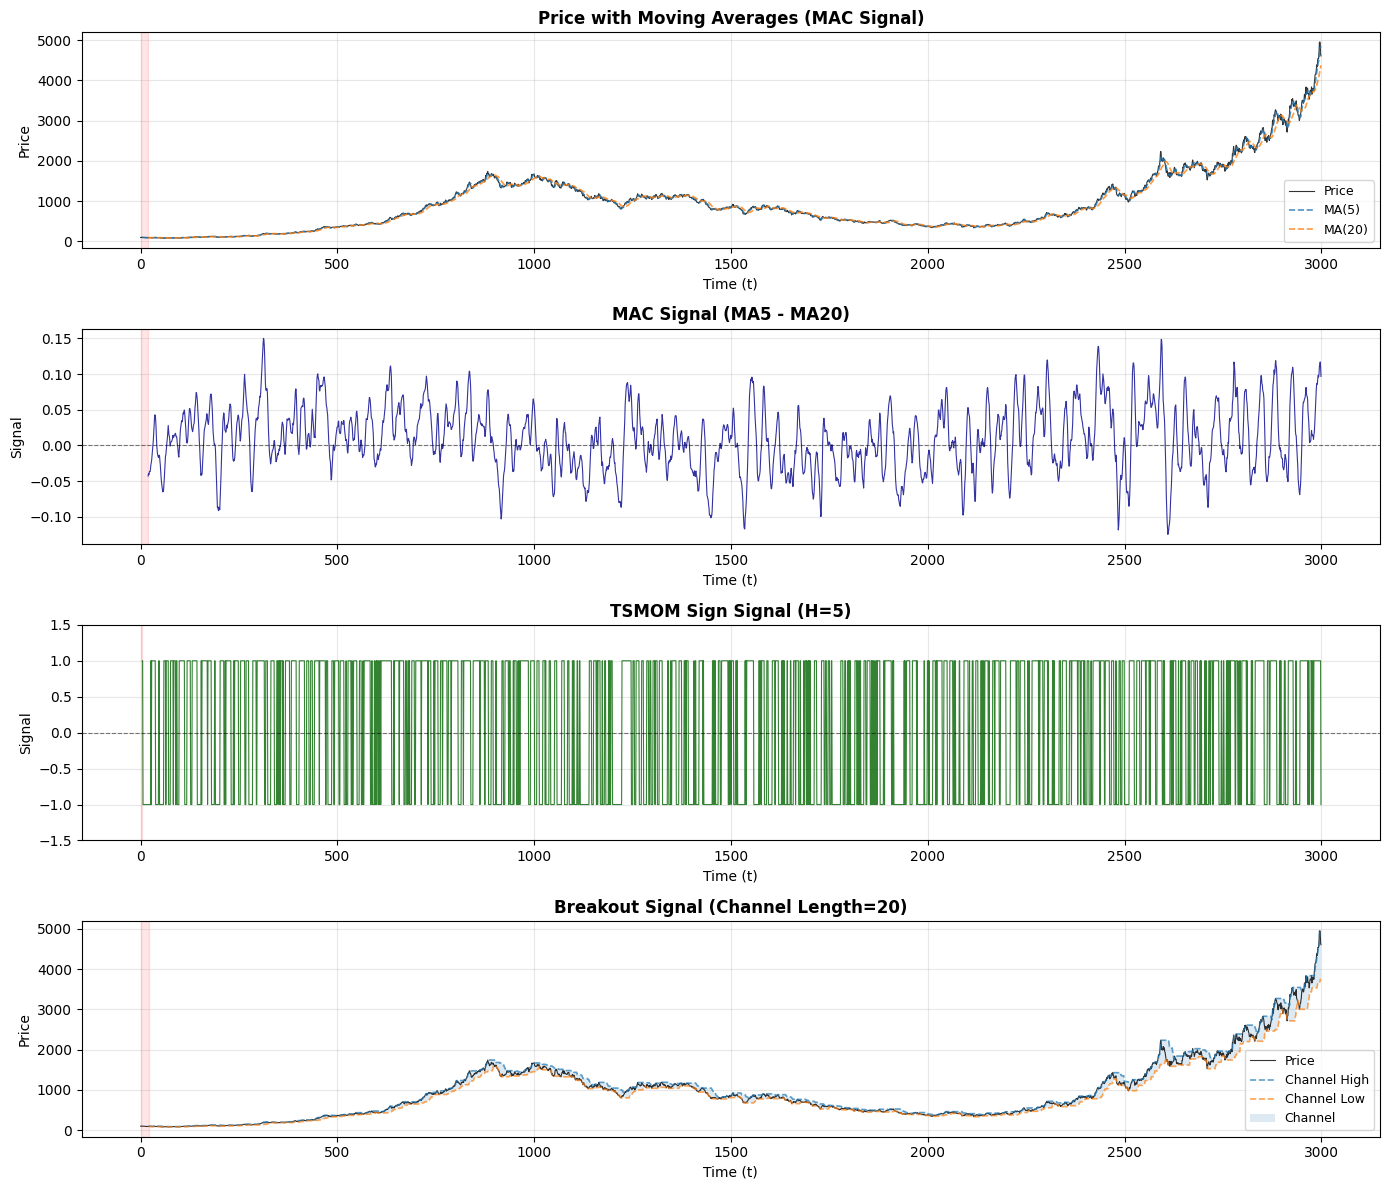

✓ Plot saved: trend_signals.png

SIGNAL GENERATION COMPLETE

Summary:
  MAC: 2981 valid observations
  TSMOM: 2996 valid observations
  Breakout: 2980 valid observations

Next step: Map signals to positions (Cell 7)



In [22]:
# Cell 6 — Canonical Trend Signals (MAC, TSMOM, Breakout)
print("=" * 80)
print("CANONICAL TREND SIGNALS")
print("=" * 80)
print()
print("Implementing three foundational trend-following approaches:")
print("  A) Moving Average Crossover (MAC)")
print("  B) Time Series Momentum (TSMOM)")
print("  C) Channel Breakout")
print()
print("Each signal represents a different filtering/decision paradigm.")
print("All signals are STRICTLY CAUSAL (no look-ahead bias).")
print()

# ============================================================================
# A) MOVING AVERAGE CROSSOVER (MAC)
# ============================================================================
print("=" * 40)
print("A) MOVING AVERAGE CROSSOVER (MAC)")
print("=" * 40)
print()
print("CONCEPT:")
print("  Compare short-term vs long-term moving averages of log-price.")
print("  Signal = MA_short - MA_long")
print("  Positive signal → uptrend (short MA above long MA)")
print("  Negative signal → downtrend (short MA below long MA)")
print()

# Extract base window from config
L_short, L_long = CONFIG["signals"]["MAC"]["base_window"]
print(f"Parameters:")
print(f"  Short window: {L_short}")
print(f"  Long window: {L_long}")
print()

# Compute moving averages on log-price (x)
# Why log-price? Differences in log-price equal log-returns,
# making the signal interpretable in return space
ma_short = rolling_mean(x, L_short)
ma_long = rolling_mean(x, L_long)

# Signal: difference between short and long MA
# Positive → short MA above long MA → bullish
# Negative → short MA below long MA → bearish
s_mac = ma_short - ma_long

# Report warmup period
warmup_mac = L_long - 1
print(f"✓ MAC signal computed")
print(f"  Warmup period: first {warmup_mac} observations are NaN")
print(f"  Valid observations: {np.sum(~np.isnan(s_mac))} / {len(s_mac)}")
print(f"  Signal range: [{np.nanmin(s_mac):.6f}, {np.nanmax(s_mac):.6f}]")
print(f"  Signal mean: {np.nanmean(s_mac):.6f}")
print(f"  Signal std: {np.nanstd(s_mac):.6f}")
print()

# ============================================================================
# B) TIME SERIES MOMENTUM (TSMOM)
# ============================================================================
print("=" * 40)
print("B) TIME SERIES MOMENTUM (TSMOM)")
print("=" * 40)
print()
print("CONCEPT:")
print("  Measure cumulative return over past H periods.")
print("  r_H[t] = sum(r[t-H+1], ..., r[t])")
print("  Sign variant: signal = sign(r_H)")
print("  Scaled variant: signal = r_H / volatility (placeholder for Ch10)")
print()

# Base horizon from config
H_base = CONFIG["signals"]["TSMOM"]["base_horizon"]
print(f"Parameters:")
print(f"  Base horizon: {H_base}")
print()

# Compute cumulative return over past H periods
# r_H[t] represents total return looking back H periods ending at t
r_H = rolling_sum(r, H_base)

# Sign variant: simple directional signal
# Positive → positive momentum → long
# Negative → negative momentum → short
s_tsmom_sign = np.sign(r_H)

print(f"✓ TSMOM sign signal computed")
print(f"  Warmup period: first {H_base-1} observations are NaN")
print(f"  Valid observations: {np.sum(~np.isnan(s_tsmom_sign))} / {len(s_tsmom_sign)}")
print(f"  Signal values: {np.unique(s_tsmom_sign[~np.isnan(s_tsmom_sign)])}")
print(f"  Distribution: +1: {np.sum(s_tsmom_sign == 1)}, -1: {np.sum(s_tsmom_sign == -1)}, 0: {np.sum(s_tsmom_sign == 0)}")
print()

# Scaled variant (PLACEHOLDER - not full Chapter 10 implementation)
print("Computing scaled variant (PLACEHOLDER):")
print("  NOTE: This is NOT the full volatility-scaling from Chapter 10.")
print("  We compute a simple rolling RMS as a proxy for realized volatility.")
print("  Full implementation would use EWMA, outlier-robust estimators, etc.")
print()

# Simple rolling RMS of returns as volatility proxy
rolling_rms = np.sqrt(rolling_mean(r**2, H_base))
eps = CONFIG["signals"]["TSMOM"]["scaling_epsilon"]

# Scaled signal: return divided by volatility
# Interpretation: Sharpe-ratio-like signal (return per unit risk)
s_tsmom_scaled = r_H / (rolling_rms + eps)

print(f"✓ TSMOM scaled signal computed")
print(f"  Signal range: [{np.nanmin(s_tsmom_scaled):.4f}, {np.nanmax(s_tsmom_scaled):.4f}]")
print(f"  Signal mean: {np.nanmean(s_tsmom_scaled):.4f}")
print(f"  Signal std: {np.nanstd(s_tsmom_scaled):.4f}")
print()

# ============================================================================
# C) CHANNEL BREAKOUT
# ============================================================================
print("=" * 40)
print("C) CHANNEL BREAKOUT")
print("=" * 40)
print()
print("CONCEPT:")
print("  Define a channel using highest/lowest prices over past L bars.")
print("  Signal:")
print("    +1 if price breaks ABOVE channel high → buy breakout")
print("    -1 if price breaks BELOW channel low → sell breakout")
print("     0 if price inside channel → no position")
print()

# Extract parameters
L_channel = CONFIG["signals"]["Breakout"]["channel_length"]
exclude_current = CONFIG["signals"]["Breakout"]["exclude_current"]

print(f"Parameters:")
print(f"  Channel length: {L_channel}")
print(f"  Exclude current: {exclude_current}")
print()

if exclude_current:
    print("CAUSALITY NOTE:")
    print("  exclude_current=True ensures no look-ahead bias.")
    print("  At time t, we compute channel from p[t-L] to p[t-1] (NOT including p[t])")
    print("  Then we compare p[t] to this HISTORICAL channel.")
    print("  This is the only causally valid way to implement breakouts.")
    print()

# Compute channel bounds
# high[t] = max of previous L prices (excluding current)
# low[t] = min of previous L prices (excluding current)
channel_high = rolling_max(p, L_channel, exclude_current=exclude_current)
channel_low = rolling_min(p, L_channel, exclude_current=exclude_current)

# Generate breakout signal
# Logic:
#   if p[t] > channel_high[t]: +1 (breakout above)
#   if p[t] < channel_low[t]: -1 (breakout below)
#   otherwise: 0 (inside channel, no signal)
s_breakout = np.zeros_like(p, dtype=float)
s_breakout[p > channel_high] = 1.0
s_breakout[p < channel_low] = -1.0

# Handle NaN warmup (where channel not yet defined)
s_breakout[np.isnan(channel_high)] = np.nan
s_breakout[np.isnan(channel_low)] = np.nan

warmup_breakout = L_channel if exclude_current else L_channel - 1
print(f"✓ Breakout signal computed")
print(f"  Warmup period: first {warmup_breakout} observations are NaN")
print(f"  Valid observations: {np.sum(~np.isnan(s_breakout))} / {len(s_breakout)}")
print()
print(f"Signal distribution:")
print(f"  +1 (long breakout): {np.sum(s_breakout == 1)} observations ({np.sum(s_breakout == 1)/np.sum(~np.isnan(s_breakout))*100:.1f}%)")
print(f"  -1 (short breakout): {np.sum(s_breakout == -1)} observations ({np.sum(s_breakout == -1)/np.sum(~np.isnan(s_breakout))*100:.1f}%)")
print(f"   0 (inside channel): {np.sum(s_breakout == 0)} observations ({np.sum(s_breakout == 0)/np.sum(~np.isnan(s_breakout))*100:.1f}%)")
print()

# ============================================================================
# PLOT SIGNALS ALIGNED WITH PRICE
# ============================================================================
print("=" * 40)
print("VISUALIZATION")
print("=" * 40)
print()
print("Generating plots: signals aligned with price...")

fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# ------------------------------------------------------------------------
# Subplot 1: Price with Moving Averages
# ------------------------------------------------------------------------
axes[0].plot(p, linewidth=0.8, label='Price', alpha=0.8, color='black')
axes[0].plot(np.exp(ma_short), linewidth=1.2, label=f'MA({L_short})',
             linestyle='--', alpha=0.8)
axes[0].plot(np.exp(ma_long), linewidth=1.2, label=f'MA({L_long})',
             linestyle='--', alpha=0.8)
axes[0].set_title("Price with Moving Averages (MAC Signal)",
                   fontsize=12, fontweight='bold')
axes[0].set_xlabel("Time (t)")
axes[0].set_ylabel("Price")
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)

# Shade warmup region
axes[0].axvspan(0, warmup_mac, alpha=0.1, color='red',
                label=f'Warmup ({warmup_mac} bars)')

# ------------------------------------------------------------------------
# Subplot 2: MAC Signal
# ------------------------------------------------------------------------
axes[1].plot(s_mac, linewidth=0.8, color='darkblue', alpha=0.8)
axes[1].axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
axes[1].set_title(f"MAC Signal (MA{L_short} - MA{L_long})",
                   fontsize=12, fontweight='bold')
axes[1].set_xlabel("Time (t)")
axes[1].set_ylabel("Signal")
axes[1].grid(True, alpha=0.3)
axes[1].axvspan(0, warmup_mac, alpha=0.1, color='red')

# ------------------------------------------------------------------------
# Subplot 3: TSMOM Sign Signal
# ------------------------------------------------------------------------
axes[2].plot(s_tsmom_sign, linewidth=0.8, color='darkgreen', alpha=0.8)
axes[2].axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
axes[2].set_title(f"TSMOM Sign Signal (H={H_base})",
                   fontsize=12, fontweight='bold')
axes[2].set_xlabel("Time (t)")
axes[2].set_ylabel("Signal")
axes[2].set_ylim(-1.5, 1.5)
axes[2].grid(True, alpha=0.3)
axes[2].axvspan(0, H_base-1, alpha=0.1, color='red')

# ------------------------------------------------------------------------
# Subplot 4: Breakout Signal with Channel
# ------------------------------------------------------------------------
axes[3].plot(p, linewidth=0.8, label='Price', alpha=0.8, color='black')
axes[3].plot(channel_high, linewidth=1.2, label='Channel High',
             linestyle='--', alpha=0.7)
axes[3].plot(channel_low, linewidth=1.2, label='Channel Low',
             linestyle='--', alpha=0.7)
axes[3].fill_between(range(len(p)), channel_low, channel_high,
                      alpha=0.15, label='Channel')
axes[3].set_title(f"Breakout Signal (Channel Length={L_channel})",
                   fontsize=12, fontweight='bold')
axes[3].set_xlabel("Time (t)")
axes[3].set_ylabel("Price")
axes[3].legend(loc='best', fontsize=9)
axes[3].grid(True, alpha=0.3)
axes[3].axvspan(0, warmup_breakout, alpha=0.1, color='red')

plt.tight_layout()
plt.savefig('trend_signals.png', dpi=100, bbox_inches='tight')
plt.show()
print("✓ Plot saved: trend_signals.png")
print()

print("=" * 80)
print("SIGNAL GENERATION COMPLETE")
print("=" * 80)
print()
print("Summary:")
print(f"  MAC: {np.sum(~np.isnan(s_mac))} valid observations")
print(f"  TSMOM: {np.sum(~np.isnan(s_tsmom_sign))} valid observations")
print(f"  Breakout: {np.sum(~np.isnan(s_breakout))} valid observations")
print()
print("Next step: Map signals to positions (Cell 7)")
print()

##7.FROM SIGNALS TO POSITIONS

###7.1.OVERVIEW

This section transforms abstract signals into executable trading positions through a
three-stage pipeline: mapping, execution lag, and constraints. This pipeline
embodies the critical distinction between what we want to do (signal) and what
we can actually do (constrained, lagged position).

The mapping stage offers three paradigms. Binary mapping produces simple long/short
positions: w = sign(signal) * w_max, yielding {-1, 0, +1} scaled by maximum
leverage. Ternary mapping adds a deadzone requiring minimum signal strength before
taking positions, reducing whipsaws in noisy markets. Continuous mapping uses
tanh or linear clipping to scale position size with signal strength, creating
smoother transitions and partial positions.

Execution lag is the critical causality enforcement mechanism. We cannot trade on
information at time t until t+1—signals must be computed, orders routed, and
executions confirmed. The apply_execution_lag function implements w[t+1] = f(signal[t])
by shifting the desired position array forward one period. This single line prevents
the most common backtest error: assuming instantaneous execution with zero latency.

Constraints layer reality onto idealized positions. Leverage bounds clip positions
to [-w_max, +w_max], preventing over-leveraging. Optional turnover limits constrain
how much positions can change per period, controlling transaction costs and avoiding
rapid oscillations when signals flip frequently.

The visualization uses step plots (not line plots) because positions are held
constant within each period—they're piecewise constant functions, not continuous
curves. Each strategy's position time series clearly shows periods of long exposure
(+1), short exposure (-1), and neutrality (0), with the execution lag visible as
the offset between signal changes and position changes.

###7.2.CODE AND IMPLEMENTATION

SIGNAL TO POSITION MAPPING

This cell transforms raw signals into executable positions.
Key components:
  1. Mapping functions: signal → desired position
  2. Execution lag: enforce w[t+1] = f(signal[t])
  3. Constraints: leverage bounds, turnover limits

PARAMETERS

Position Mapping:
  Type: binary
  Max leverage (w_max): 1.0
  Deadzone threshold (tau): 0.0
  Continuous scaling (k): 1.0
  Saturation type: tanh

Execution:
  Lag: 1 (signal[t] → position[t+1])
  Turnover limit: None (unlimited)

GENERATING POSITIONS

1) MAC (Moving Average Crossover)
----------------------------------------
  ✓ Positions computed
  Non-zero positions: 2999 / 3000 (100.0%)
  Valid (non-NaN): 2981
  Position range: [-1.0000, 1.0000]
  Distribution: +1.0: 1706, 0: 1, -1.0: 1274

2) TSMOM (Time Series Momentum)
----------------------------------------
  ✓ Positions computed
  Non-zero positions: 2999 / 3000 (100.0%)
  Valid (non-NaN): 2996
  Position range: [-1.0000, 1.0000]
  Distribution: +1.0: 1657, 0: 1

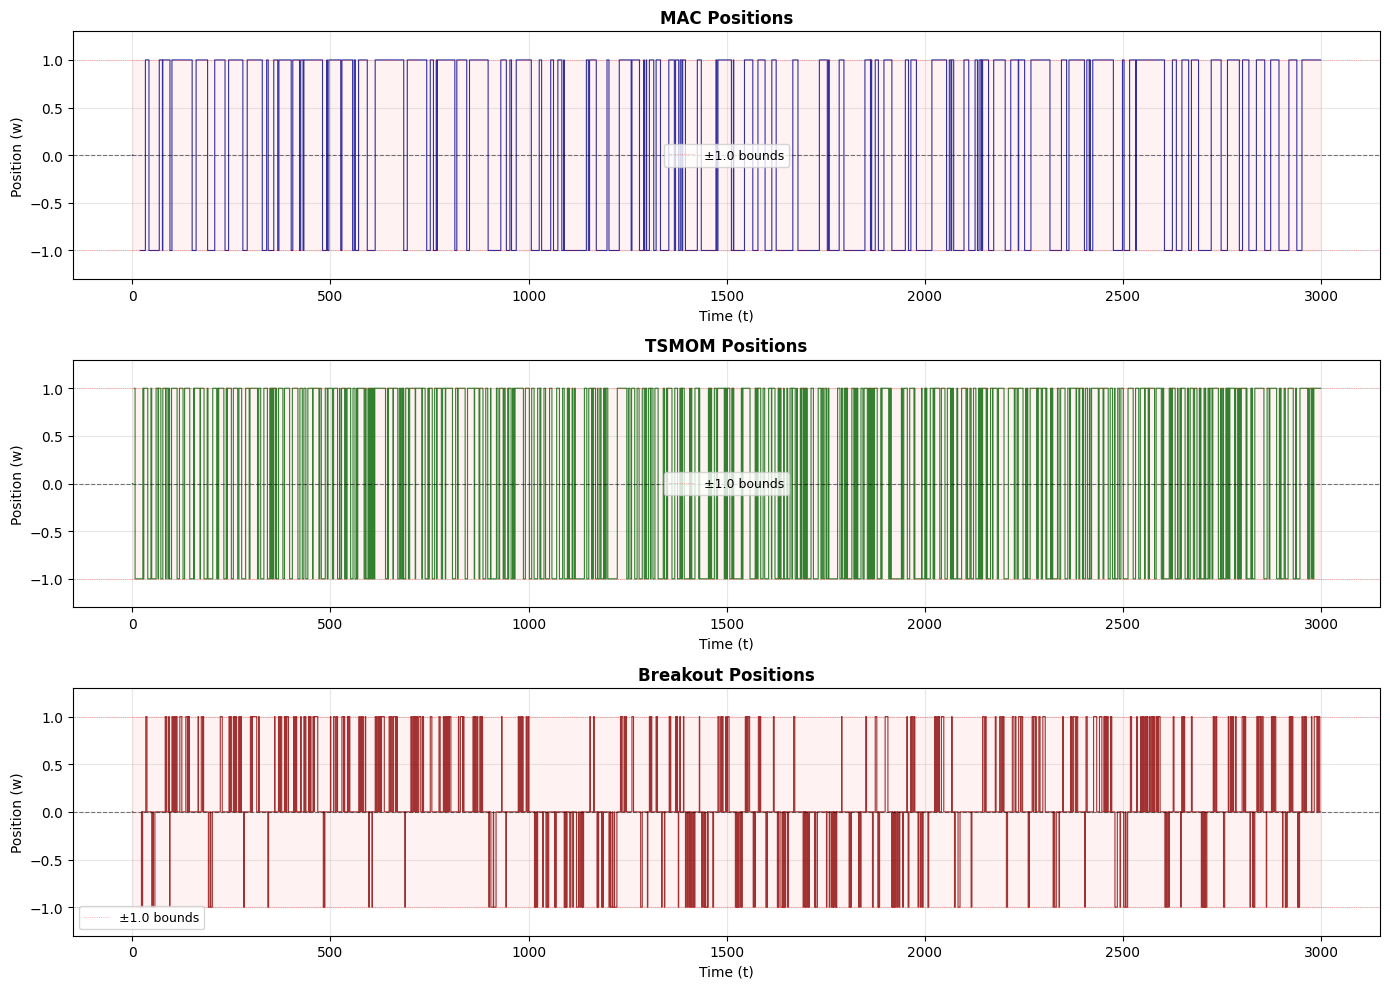

✓ Plot saved: positions.png

POSITION GENERATION COMPLETE

Summary:
  MAC: 2999 non-zero positions
  TSMOM: 2999 non-zero positions
  Breakout: 809 non-zero positions

Execution lag: 1 (ensures causality)
Leverage bounds: ±1.0

Next step: Backtest strategies (Cell 8)



In [23]:
# Cell 7 — From Signals to Positions (Mapping + Constraints)
print("=" * 80)
print("SIGNAL TO POSITION MAPPING")
print("=" * 80)
print()
print("This cell transforms raw signals into executable positions.")
print("Key components:")
print("  1. Mapping functions: signal → desired position")
print("  2. Execution lag: enforce w[t+1] = f(signal[t])")
print("  3. Constraints: leverage bounds, turnover limits")
print()

# ============================================================================
# MAPPING FUNCTIONS
# ============================================================================

def map_signal_to_position(signal, mapping_type, w_max, tau=0.0, k=1.0, saturation_type='tanh'):
    """
    Map signal to desired position with various mapping types.

    MAPPING TYPES:

    1) BINARY:
        w = sign(signal) * w_max
        Produces: {-w_max, 0, +w_max}
        Use case: Simple long/short based on signal direction

    2) TERNARY (with deadzone):
        w = +w_max if signal > tau
        w = -w_max if signal < -tau
        w = 0 otherwise
        Use case: Require minimum signal strength before taking position

    3) CONTINUOUS:
        w = tanh(k * signal) * w_max  OR  w = clip(k * signal, -w_max, w_max)
        Produces: continuous values in [-w_max, +w_max]
        Use case: Position size scales with signal strength

    Args:
        signal: signal array (T,)
        mapping_type: 'binary', 'ternary', or 'continuous'
        w_max: maximum leverage bound (|w| <= w_max)
        tau: deadzone threshold for ternary (signal must exceed ±tau)
        k: scaling factor for continuous (controls saturation speed)
        saturation_type: 'tanh' or 'clip' for continuous mapping

    Returns:
        w_desired: desired position array (T,) before execution lag
    """
    T = len(signal)
    w_desired = np.full(T, np.nan, dtype=float)

    if mapping_type == 'binary':
        # Simple sign mapping: -w_max, 0, or +w_max
        w_desired = np.sign(signal) * w_max

    elif mapping_type == 'ternary':
        # Deadzone mapping: require signal strength > tau
        w_desired = np.zeros(T, dtype=float)
        w_desired[signal > tau] = w_max
        w_desired[signal < -tau] = -w_max
        # Preserve NaN from signal
        w_desired[np.isnan(signal)] = np.nan

    elif mapping_type == 'continuous':
        # Smooth mapping with saturation
        if saturation_type == 'tanh':
            # tanh provides smooth saturation: tanh(±∞) → ±1
            # k controls how quickly we saturate (large k → faster saturation)
            w_desired = np.tanh(k * signal) * w_max
        elif saturation_type == 'clip':
            # Linear with hard clipping at ±w_max
            w_desired = clip(k * signal, -w_max, w_max)
        else:
            raise ValueError(f"Unknown saturation_type: {saturation_type}")

    else:
        raise ValueError(f"Unknown mapping_type: {mapping_type}")

    return w_desired


def apply_execution_lag(w_desired, lag=1):
    """
    Apply execution lag: position at t+lag is based on signal at t.

    CRITICAL CAUSALITY CONSTRAINT:
        We compute desired position from signal[t], but we cannot
        execute until t+lag. This prevents impossible same-bar execution.

    IMPLEMENTATION:
        w[t+lag] = w_desired[t]

        Equivalently: w = shift_right(w_desired, lag)

        This means:
            w[0], w[1], ..., w[lag-1] = 0 (or fill_value)
            w[lag] = w_desired[0]
            w[lag+1] = w_desired[1]
            ...

    TYPICAL USAGE:
        lag=1 means "signal at close of day t, trade at close of day t+1"
        This accounts for: signal computation time, order routing, execution

    Args:
        w_desired: desired position array (T,) from signal
        lag: number of periods to delay execution (typically 1)

    Returns:
        w: position array (T,) with execution lag applied
    """
    return shift_right(w_desired, lag, fill_value=0.0)


def apply_constraints(w, w_max, turnover_limit=None):
    """
    Apply position constraints:
    1. Leverage bound: |w[t]| <= w_max
    2. Turnover limit (optional): |w[t] - w[t-1]| <= delta_max

    LEVERAGE BOUND:
        Simple clipping to enforce maximum position size.
        Prevents over-leveraging.

    TURNOVER LIMIT:
        Limits how much position can change per period.
        Use case: Control trading costs, avoid rapid oscillations.

        Implementation:
            If |w[t] - w[t-1]| > delta_max:
                w[t] = w[t-1] + sign(change) * delta_max

    NOTE: Constraints are applied AFTER execution lag.
          This means they operate on the timeline of actual positions.

    Args:
        w: position array (T,)
        w_max: maximum leverage bound
        turnover_limit: maximum position change per period (None = no limit)

    Returns:
        w_constrained: position array (T,) with constraints applied
    """
    T = len(w)
    w_constrained = w.copy()

    # 1. Leverage bound: clip to [-w_max, +w_max]
    w_constrained = clip(w_constrained, -w_max, w_max)

    # 2. Turnover limit (if specified)
    if turnover_limit is not None:
        for t in range(1, T):
            # Compute desired change
            delta = w_constrained[t] - w_constrained[t-1]

            # If change exceeds limit, constrain it
            if np.abs(delta) > turnover_limit:
                w_constrained[t] = w_constrained[t-1] + np.sign(delta) * turnover_limit

    return w_constrained


# ============================================================================
# EXTRACT PARAMETERS FROM CONFIG
# ============================================================================
print("=" * 40)
print("PARAMETERS")
print("=" * 40)
print()

mapping_type = CONFIG["positions"]["mapping_type"]
w_max = CONFIG["positions"]["w_max"]
tau = CONFIG["positions"]["deadzone_tau"]
k = CONFIG["positions"]["continuous_k"]
saturation_type = CONFIG["positions"]["saturation_type"]
execution_lag = CONFIG["execution"]["lag"]
turnover_limit = CONFIG["positions"]["turnover_limit"]

print(f"Position Mapping:")
print(f"  Type: {mapping_type}")
print(f"  Max leverage (w_max): {w_max}")
print(f"  Deadzone threshold (tau): {tau}")
print(f"  Continuous scaling (k): {k}")
print(f"  Saturation type: {saturation_type}")
print()
print(f"Execution:")
print(f"  Lag: {execution_lag} (signal[t] → position[t+{execution_lag}])")
print(f"  Turnover limit: {turnover_limit if turnover_limit else 'None (unlimited)'}")
print()

# ============================================================================
# MAP EACH SIGNAL TO POSITIONS
# ============================================================================
print("=" * 40)
print("GENERATING POSITIONS")
print("=" * 40)
print()

# ------------------------------------------------------------------------
# MAC POSITIONS
# ------------------------------------------------------------------------
print("1) MAC (Moving Average Crossover)")
print("-" * 40)

w_mac_desired = map_signal_to_position(s_mac, mapping_type, w_max, tau, k, saturation_type)
w_mac = apply_execution_lag(w_mac_desired, lag=execution_lag)
w_mac = apply_constraints(w_mac, w_max, turnover_limit)

non_zero_mac = np.sum(w_mac != 0)
non_nan_mac = np.sum(~np.isnan(w_mac))
print(f"  ✓ Positions computed")
print(f"  Non-zero positions: {non_zero_mac} / {len(w_mac)} ({non_zero_mac/len(w_mac)*100:.1f}%)")
print(f"  Valid (non-NaN): {non_nan_mac}")
print(f"  Position range: [{np.nanmin(w_mac):.4f}, {np.nanmax(w_mac):.4f}]")

if mapping_type == 'binary':
    print(f"  Distribution: +{w_max}: {np.sum(w_mac == w_max)}, 0: {np.sum(w_mac == 0)}, -{w_max}: {np.sum(w_mac == -w_max)}")

print()

# ------------------------------------------------------------------------
# TSMOM POSITIONS (using sign signal)
# ------------------------------------------------------------------------
print("2) TSMOM (Time Series Momentum)")
print("-" * 40)

w_tsmom_desired = map_signal_to_position(s_tsmom_sign, mapping_type, w_max, tau, k, saturation_type)
w_tsmom = apply_execution_lag(w_tsmom_desired, lag=execution_lag)
w_tsmom = apply_constraints(w_tsmom, w_max, turnover_limit)

non_zero_tsmom = np.sum(w_tsmom != 0)
non_nan_tsmom = np.sum(~np.isnan(w_tsmom))
print(f"  ✓ Positions computed")
print(f"  Non-zero positions: {non_zero_tsmom} / {len(w_tsmom)} ({non_zero_tsmom/len(w_tsmom)*100:.1f}%)")
print(f"  Valid (non-NaN): {non_nan_tsmom}")
print(f"  Position range: [{np.nanmin(w_tsmom):.4f}, {np.nanmax(w_tsmom):.4f}]")

if mapping_type == 'binary':
    print(f"  Distribution: +{w_max}: {np.sum(w_tsmom == w_max)}, 0: {np.sum(w_tsmom == 0)}, -{w_max}: {np.sum(w_tsmom == -w_max)}")

print()

# ------------------------------------------------------------------------
# BREAKOUT POSITIONS
# ------------------------------------------------------------------------
print("3) BREAKOUT (Channel Breakout)")
print("-" * 40)

w_breakout_desired = map_signal_to_position(s_breakout, mapping_type, w_max, tau, k, saturation_type)
w_breakout = apply_execution_lag(w_breakout_desired, lag=execution_lag)
w_breakout = apply_constraints(w_breakout, w_max, turnover_limit)

non_zero_breakout = np.sum(w_breakout != 0)
non_nan_breakout = np.sum(~np.isnan(w_breakout))
print(f"  ✓ Positions computed")
print(f"  Non-zero positions: {non_zero_breakout} / {len(w_breakout)} ({non_zero_breakout/len(w_breakout)*100:.1f}%)")
print(f"  Valid (non-NaN): {non_nan_breakout}")
print(f"  Position range: [{np.nanmin(w_breakout):.4f}, {np.nanmax(w_breakout):.4f}]")

if mapping_type == 'binary':
    print(f"  Distribution: +{w_max}: {np.sum(w_breakout == w_max)}, 0: {np.sum(w_breakout == 0)}, -{w_max}: {np.sum(w_breakout == -w_max)}")

print()

# ============================================================================
# PLOT POSITIONS OVER TIME
# ============================================================================
print("=" * 40)
print("VISUALIZATION")
print("=" * 40)
print()
print("Generating position plots...")

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# ------------------------------------------------------------------------
# Subplot 1: MAC Positions
# ------------------------------------------------------------------------
axes[0].step(range(len(w_mac)), w_mac, where='post', linewidth=0.8, color='darkblue', alpha=0.8)
axes[0].axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
axes[0].axhline(w_max, color='red', linewidth=0.5, linestyle=':', alpha=0.5, label=f'±{w_max} bounds')
axes[0].axhline(-w_max, color='red', linewidth=0.5, linestyle=':', alpha=0.5)
axes[0].fill_between(range(len(w_mac)), -w_max, w_max, alpha=0.05, color='red')
axes[0].set_title("MAC Positions", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Time (t)")
axes[0].set_ylabel("Position (w)")
axes[0].set_ylim(-w_max*1.3, w_max*1.3)
axes[0].legend(loc='best', fontsize=9)
axes[0].grid(True, alpha=0.3)

# ------------------------------------------------------------------------
# Subplot 2: TSMOM Positions
# ------------------------------------------------------------------------
axes[1].step(range(len(w_tsmom)), w_tsmom, where='post', linewidth=0.8, color='darkgreen', alpha=0.8)
axes[1].axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
axes[1].axhline(w_max, color='red', linewidth=0.5, linestyle=':', alpha=0.5, label=f'±{w_max} bounds')
axes[1].axhline(-w_max, color='red', linewidth=0.5, linestyle=':', alpha=0.5)
axes[1].fill_between(range(len(w_tsmom)), -w_max, w_max, alpha=0.05, color='red')
axes[1].set_title("TSMOM Positions", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Time (t)")
axes[1].set_ylabel("Position (w)")
axes[1].set_ylim(-w_max*1.3, w_max*1.3)
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)

# ------------------------------------------------------------------------
# Subplot 3: Breakout Positions
# ------------------------------------------------------------------------
axes[2].step(range(len(w_breakout)), w_breakout, where='post', linewidth=0.8, color='darkred', alpha=0.8)
axes[2].axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
axes[2].axhline(w_max, color='red', linewidth=0.5, linestyle=':', alpha=0.5, label=f'±{w_max} bounds')
axes[2].axhline(-w_max, color='red', linewidth=0.5, linestyle=':', alpha=0.5)
axes[2].fill_between(range(len(w_breakout)), -w_max, w_max, alpha=0.05, color='red')
axes[2].set_title("Breakout Positions", fontsize=12, fontweight='bold')
axes[2].set_xlabel("Time (t)")
axes[2].set_ylabel("Position (w)")
axes[2].set_ylim(-w_max*1.3, w_max*1.3)
axes[2].legend(loc='best', fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('positions.png', dpi=100, bbox_inches='tight')
plt.show()
print("✓ Plot saved: positions.png")
print()

print("=" * 80)
print("POSITION GENERATION COMPLETE")
print("=" * 80)
print()
print("Summary:")
print(f"  MAC: {non_zero_mac} non-zero positions")
print(f"  TSMOM: {non_zero_tsmom} non-zero positions")
print(f"  Breakout: {non_zero_breakout} non-zero positions")
print()
print(f"Execution lag: {execution_lag} (ensures causality)")
print(f"Leverage bounds: ±{w_max}")
print()
print("Next step: Backtest strategies (Cell 8)")
print()

##8.BACKTEST ENGINE

###8.1.OVERVIEW

This section implements the backtest engine that transforms positions and market returns
into portfolio performance metrics. This is where theoretical signals become
concrete P&L measurements. The backtest function operates on a simple but critical
principle: portfolio return pi[t] = w[t] * r[t], where w[t] is the position held
during period [t, t+1) and r[t] is the realized return during that period.

The equity curve is constructed as the cumulative sum of portfolio returns,
representing the strategy's wealth trajectory over time. This log-return formulation
ensures additive compounding and numerical stability. The engine computes thirteen
performance metrics spanning four categories: return statistics (total return,
annualized return, volatility), risk-adjusted performance (Sharpe ratio assuming
zero risk-free rate), risk metrics (maximum drawdown measuring peak-to-trough
decline), and operational metrics (turnover, number of trades, hit rate, win/loss
statistics).

Critical design features ensure production readiness. NaN handling replaces missing
position values with zero rather than propagating errors through calculations. The
metrics computation distinguishes between total time periods and actively positioned
periods—evaluating performance only when capital is at risk. Drawdown calculation
uses cumulative maximum tracking to identify the worst peak-to-trough decline
without loops.

The visualization employs a two-panel layout: equity curves with regime shading
showing when different market conditions prevailed, and filled drawdown plots
revealing the timing and magnitude of losses. Text annotations display final returns
and maximum drawdowns directly on the plots, eliminating the need to cross-reference
tables. The interpretation section automatically identifies the best-performing
strategy by Sharpe ratio, lowest drawdown, and lowest turnover—providing immediate
actionable insights without manual analysis.

###8.2.CODE AND IMPLEMENTATION

BACKTEST ENGINE

Simple causal backtest for single-instrument strategies.
Computes P&L, equity curves, and performance metrics.

CRITICAL INDEXING CONVENTION:
  w[t] = position held during period [t, t+1)
  r[t] = return during period [t-1, t)
  Therefore: pi[t] = w[t] * r[t]

RUNNING BACKTESTS

Annualization factor: 252 (assuming daily data)

Computing performance metrics...
✓ Backtests complete

BACKTEST METRICS

Metric                         MAC             TSMOM           Breakout       
--------------------------------------------------------------------------------
Total Return                   1.4197          1.0957          1.4674         
Annualized Return              0.1201          0.0922          0.4687         
Annualized Vol                 0.3604          0.3597          0.3657         
Sharpe Ratio                   0.3331          0.2563          1.2815         
Max Drawdown                   -0.9451         -0.8883         -0.4023        
Turnover (total)          

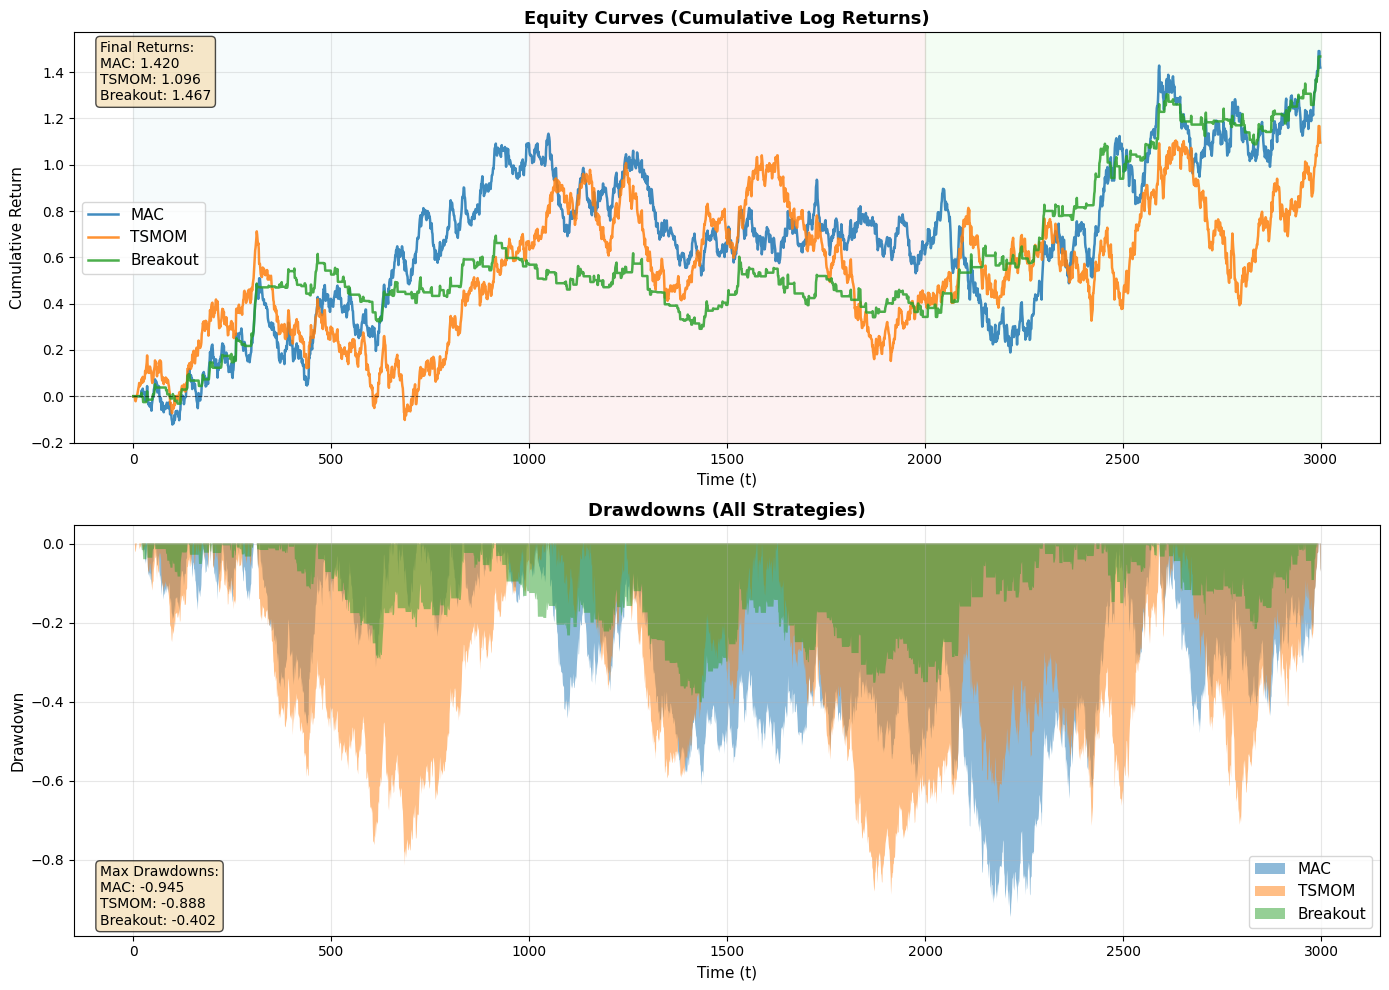

✓ Plot saved: backtest_results.png

BACKTEST COMPLETE

All three trend-following strategies have been backtested.
Equity curves show cumulative performance over time.
Drawdowns visualize peak-to-trough declines.

Key observations:
  • Best strategy by Sharpe: Breakout
  • Total return range: [1.096, 1.467]
  • All strategies tested with strict causality (lag=1)

Next step: Causality gates to verify no look-ahead bias (Cell 9)



In [26]:
# Cell 8 — Backtest Engine (COMPLETE PROFESSIONAL VERSION)
print("=" * 80)
print("BACKTEST ENGINE")
print("=" * 80)
print()
print("Simple causal backtest for single-instrument strategies.")
print("Computes P&L, equity curves, and performance metrics.")
print()
print("CRITICAL INDEXING CONVENTION:")
print("  w[t] = position held during period [t, t+1)")
print("  r[t] = return during period [t-1, t)")
print("  Therefore: pi[t] = w[t] * r[t]")
print()

# ============================================================================
# BACKTEST FUNCTION
# ============================================================================

def backtest_strategy(w, r, annualization_factor=252):
    """
    Complete causal backtest for single instrument.

    PORTFOLIO RETURN CALCULATION:
        pi[t] = w[t] * r[t]

    EQUITY CURVE:
        equity[t] = cumsum(pi)

    METRICS:
        - Total return, annualized return, volatility
        - Sharpe ratio (risk-free = 0)
        - Max drawdown
        - Turnover and number of trades
        - Hit rate and win/loss statistics

    Args:
        w: position array (T,)
        r: return array (T,)
        annualization_factor: periods per year (252 for daily)

    Returns:
        dict with pi, equity, and comprehensive metrics
    """
    T = len(w)
    assert len(r) == T, "Position and return arrays must have same length"

    # Clean NaN in positions (replace with 0)
    w_clean = np.nan_to_num(w, nan=0.0)

    # Portfolio returns: element-wise product
    pi = w_clean * r

    # Clean any NaN in returns
    pi = np.nan_to_num(pi, nan=0.0)

    # Equity curve: cumulative sum of log-returns
    equity = np.cumsum(pi)

    # Identify valid observations for metrics
    # Only evaluate when actively positioned (non-zero position)
    valid_idx = (w_clean != 0)
    pi_valid = pi[valid_idx]

    # Handle edge case: no valid observations
    if len(pi_valid) == 0:
        return {
            'pi': pi,
            'equity': equity,
            'metrics': {
                'total_return': 0.0,
                'annualized_return': 0.0,
                'annualized_vol': 0.0,
                'sharpe': 0.0,
                'max_drawdown': 0.0,
                'turnover': 0.0,
                'avg_turnover': 0.0,
                'hit_rate': 0.0,
                'n_trades': 0,
                'n_valid_periods': 0,
                'avg_win': 0.0,
                'avg_loss': 0.0,
                'win_loss_ratio': 0.0
            }
        }

    # ========================================================================
    # COMPUTE METRICS
    # ========================================================================

    # 1. Return metrics
    total_return = equity[-1]
    n_periods = len(pi_valid)

    # Annualized return
    ann_return = (total_return / n_periods) * annualization_factor if n_periods > 0 else 0.0

    # Annualized volatility
    ann_vol = np.std(pi_valid) * np.sqrt(annualization_factor) if len(pi_valid) > 1 else 0.0

    # Sharpe ratio (risk-free rate = 0)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0.0

    # 2. Drawdown analysis
    running_max = np.maximum.accumulate(equity)
    drawdown = equity - running_max
    max_dd = np.min(drawdown)

    # 3. Turnover metrics
    position_change = np.abs(np.diff(w_clean))
    turnover = np.sum(position_change)
    avg_turnover = turnover / T if T > 0 else 0.0

    # 4. Hit rate
    hit_rate = np.sum(pi_valid > 0) / len(pi_valid) if len(pi_valid) > 0 else 0.0

    # 5. Number of trades
    n_trades = int(np.sum(np.abs(np.diff(np.sign(w_clean))) > 0))

    # 6. Win/loss statistics
    wins = pi_valid[pi_valid > 0]
    losses = pi_valid[pi_valid < 0]

    avg_win = np.mean(wins) if len(wins) > 0 else 0.0
    avg_loss = np.mean(losses) if len(losses) > 0 else 0.0
    win_loss_ratio = avg_win / abs(avg_loss) if avg_loss != 0 else 0.0

    # Package metrics
    metrics = {
        'total_return': total_return,
        'annualized_return': ann_return,
        'annualized_vol': ann_vol,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'turnover': turnover,
        'avg_turnover': avg_turnover,
        'hit_rate': hit_rate,
        'n_trades': int(n_trades),
        'n_valid_periods': int(n_periods),
        'avg_win': avg_win,
        'avg_loss': avg_loss,
        'win_loss_ratio': win_loss_ratio
    }

    return {
        'pi': pi,
        'equity': equity,
        'metrics': metrics
    }


# ============================================================================
# RUN BACKTESTS FOR ALL STRATEGIES
# ============================================================================
print("=" * 40)
print("RUNNING BACKTESTS")
print("=" * 40)
print()

ann_factor = CONFIG["evaluation"]["annualization_factor"]
print(f"Annualization factor: {ann_factor} (assuming {CONFIG['data']['dt']} data)")
print()

print("Computing performance metrics...")
results_mac = backtest_strategy(w_mac, r, ann_factor)
results_tsmom = backtest_strategy(w_tsmom, r, ann_factor)
results_breakout = backtest_strategy(w_breakout, r, ann_factor)
print("✓ Backtests complete")
print()

# ============================================================================
# PRINT COMPREHENSIVE METRICS TABLE
# ============================================================================
print("=" * 80)
print("BACKTEST METRICS")
print("=" * 80)
print()

# Print header
print(f"{'Metric':<30} {'MAC':<15} {'TSMOM':<15} {'Breakout':<15}")
print("-" * 80)

# Metrics to display
metrics_to_show = [
    ('Total Return', 'total_return', '.4f'),
    ('Annualized Return', 'annualized_return', '.4f'),
    ('Annualized Vol', 'annualized_vol', '.4f'),
    ('Sharpe Ratio', 'sharpe', '.4f'),
    ('Max Drawdown', 'max_drawdown', '.4f'),
    ('Turnover (total)', 'turnover', '.2f'),
    ('Avg Turnover (per period)', 'avg_turnover', '.4f'),
    ('Hit Rate', 'hit_rate', '.4f'),
    ('Avg Win', 'avg_win', '.6f'),
    ('Avg Loss', 'avg_loss', '.6f'),
    ('Win/Loss Ratio', 'win_loss_ratio', '.4f'),
    ('Number of Trades', 'n_trades', 'd'),
    ('Valid Periods', 'n_valid_periods', 'd')
]

for label, key, fmt in metrics_to_show:
    val_mac = results_mac['metrics'][key]
    val_tsmom = results_tsmom['metrics'][key]
    val_breakout = results_breakout['metrics'][key]

    print(f"{label:<30} {val_mac:<15{fmt}} {val_tsmom:<15{fmt}} {val_breakout:<15{fmt}}")

print("=" * 80)
print()

# ============================================================================
# INTERPRETATION
# ============================================================================
print("INTERPRETATION:")
print("-" * 40)

# Best Sharpe
sharpes = [results_mac['metrics']['sharpe'],
           results_tsmom['metrics']['sharpe'],
           results_breakout['metrics']['sharpe']]
strategies = ['MAC', 'TSMOM', 'Breakout']
best_idx = np.argmax(sharpes)
print(f"Best Sharpe Ratio: {strategies[best_idx]} ({sharpes[best_idx]:.4f})")

# Lowest drawdown (remember: more negative = worse)
dds = [results_mac['metrics']['max_drawdown'],
       results_tsmom['metrics']['max_drawdown'],
       results_breakout['metrics']['max_drawdown']]
best_dd_idx = np.argmax(dds)  # Max = closest to zero = best
print(f"Lowest Drawdown: {strategies[best_dd_idx]} ({dds[best_dd_idx]:.4f})")

# Lowest turnover
turnovers = [results_mac['metrics']['turnover'],
             results_tsmom['metrics']['turnover'],
             results_breakout['metrics']['turnover']]
low_turn_idx = np.argmin(turnovers)
print(f"Lowest Turnover: {strategies[low_turn_idx]} ({turnovers[low_turn_idx]:.2f})")

print()

# ============================================================================
# VISUALIZATION: EQUITY CURVES AND DRAWDOWNS
# ============================================================================
print("=" * 40)
print("VISUALIZATION")
print("=" * 40)
print()
print("Generating equity curves and drawdown plots...")

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ------------------------------------------------------------------------
# Subplot 1: Equity Curves
# ------------------------------------------------------------------------
axes[0].plot(results_mac['equity'], linewidth=1.8, label='MAC', alpha=0.85)
axes[0].plot(results_tsmom['equity'], linewidth=1.8, label='TSMOM', alpha=0.85)
axes[0].plot(results_breakout['equity'], linewidth=1.8, label='Breakout', alpha=0.85)
axes[0].axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)

axes[0].set_title("Equity Curves (Cumulative Log Returns)", fontsize=13, fontweight='bold')
axes[0].set_xlabel("Time (t)", fontsize=11)
axes[0].set_ylabel("Cumulative Return", fontsize=11)
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Add regime shading
colors = ['lightblue', 'lightcoral', 'lightgreen']
for i, regime in enumerate(CONFIG["data"]["regime_schedule"]):
    axes[0].axvspan(regime["start"], regime["end"], alpha=0.1, color=colors[i % len(colors)],
                     label=f'{regime["regime_name"]}' if i < 3 else "")

# Add annotation with final values
final_text = (f"Final Returns:\n"
              f"MAC: {results_mac['equity'][-1]:.3f}\n"
              f"TSMOM: {results_tsmom['equity'][-1]:.3f}\n"
              f"Breakout: {results_breakout['equity'][-1]:.3f}")
axes[0].text(0.02, 0.98, final_text, transform=axes[0].transAxes,
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# ------------------------------------------------------------------------
# Subplot 2: Drawdowns
# ------------------------------------------------------------------------
# Compute drawdowns
equity_mac = results_mac['equity']
running_max_mac = np.maximum.accumulate(equity_mac)
drawdown_mac = equity_mac - running_max_mac

equity_tsmom = results_tsmom['equity']
running_max_tsmom = np.maximum.accumulate(equity_tsmom)
drawdown_tsmom = equity_tsmom - running_max_tsmom

equity_breakout = results_breakout['equity']
running_max_breakout = np.maximum.accumulate(equity_breakout)
drawdown_breakout = equity_breakout - running_max_breakout

# Plot
axes[1].fill_between(range(len(drawdown_mac)), drawdown_mac, 0, alpha=0.5, label='MAC')
axes[1].fill_between(range(len(drawdown_tsmom)), drawdown_tsmom, 0, alpha=0.5, label='TSMOM')
axes[1].fill_between(range(len(drawdown_breakout)), drawdown_breakout, 0, alpha=0.5, label='Breakout')

axes[1].set_title("Drawdowns (All Strategies)", fontsize=13, fontweight='bold')
axes[1].set_xlabel("Time (t)", fontsize=11)
axes[1].set_ylabel("Drawdown", fontsize=11)
axes[1].legend(loc='best', fontsize=11)
axes[1].grid(True, alpha=0.3)

# Add annotation with max drawdowns
dd_text = (f"Max Drawdowns:\n"
           f"MAC: {results_mac['metrics']['max_drawdown']:.3f}\n"
           f"TSMOM: {results_tsmom['metrics']['max_drawdown']:.3f}\n"
           f"Breakout: {results_breakout['metrics']['max_drawdown']:.3f}")
axes[1].text(0.02, 0.02, dd_text, transform=axes[1].transAxes,
             fontsize=10, verticalalignment='bottom',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('backtest_results.png', dpi=100, bbox_inches='tight')
plt.show()
print("✓ Plot saved: backtest_results.png")
print()

print("=" * 80)
print("BACKTEST COMPLETE")
print("=" * 80)
print()
print("All three trend-following strategies have been backtested.")
print("Equity curves show cumulative performance over time.")
print("Drawdowns visualize peak-to-trough declines.")
print()
print("Key observations:")
print(f"  • Best strategy by Sharpe: {strategies[best_idx]}")
print(f"  • Total return range: [{min([r['equity'][-1] for r in [results_mac, results_tsmom, results_breakout]]):.3f}, "
      f"{max([r['equity'][-1] for r in [results_mac, results_tsmom, results_breakout]]):.3f}]")
print(f"  • All strategies tested with strict causality (lag={CONFIG['execution']['lag']})")
print()
print("Next step: Causality gates to verify no look-ahead bias (Cell 9)")
print()

##9.CAUSALITY GATES

###9.1.OVERVIEW

This section implements mandatory causality tests that verify the strategy contains no
look-ahead bias—the most pernicious error in quantitative trading. These tests are
not optional diagnostics but hard gates that halt execution if violations occur.
The principle is simple: any information available at time t can only affect
decisions at time t+1 or later, never at time t itself.

Three tests provide comprehensive coverage. The Alignment Test verifies that
positions at time t do not depend on returns at time t. It perturbs a future return
and confirms that all prior positions remain unchanged. This catches same-bar
execution errors where a signal computed from data through time t incorrectly
generates a position that also applies at time t. The test accounts for signal
lookback windows and execution lags when determining which positions should be
unaffected.

The Prefix Invariance Test runs the strategy on truncated data series and verifies
that results match the corresponding prefix of the full run. If computing signals
through time t* produces different positions than computing through time T and
extracting positions up to t*, future information is leaking backward. This test
uses multiple random cutoff points to detect subtle violations.

The Future Perturbation Test adds large random noise to all returns after a cutoff
point and confirms that earlier positions remain identical. This verifies that the
entire future data segment—not just individual points—has no influence on past
decisions.

All tests use explicit tolerance checking (typically 1e-10) to distinguish genuine
violations from floating-point rounding. If any test fails, execution halts with a
detailed error message identifying the violation type and location. Only strategies
passing all three gates proceed to robustness testing.

###9.2.CODE AND IMPLEMENTATION

In [31]:
# Cell 9 — Causality Gates (Must Halt on Failure)
print("=" * 80)
print("CAUSALITY GATES (Assertion Tests)")
print("=" * 80)
print()
print("These tests MUST pass to ensure no look-ahead bias.")
print("If any test fails, execution will HALT with an error message.")
print()
print("Three critical tests:")
print("  A) Alignment Test - positions don't depend on same-period returns")
print("  B) Prefix Invariance - results identical when computed on data subset")
print("  C) Future Perturbation - future data changes don't affect past positions")
print()
print("=" * 80)
print()

# ============================================================================
# TEST A: ALIGNMENT (No Look-Ahead in Same Period)
# ============================================================================

def test_alignment(w, r, s, lag=1):
    """
    Test A: Alignment test

    Verify that:
    1. Changing r[t] does not change w[t] (w[t] depends on info up to t-1)
    2. Future return changes don't affect past positions

    This is the most critical causality check.
    """
    print("=" * 40)
    print("TEST A: ALIGNMENT (No Look-Ahead)")
    print("=" * 40)
    print()

    T = len(w)

    # Test 1: Perturb a future return and verify past positions unchanged
    test_t = T // 2
    print(f"Perturbing return at t={test_t}...")

    r_perturbed = r.copy()
    r_perturbed[test_t] += 0.1  # Large perturbation

    # Recompute signal and position using TSMOM as example
    H = CONFIG["signals"]["TSMOM"]["base_horizon"]
    r_H_perturbed = rolling_sum(r_perturbed, H)
    s_perturbed = np.sign(r_H_perturbed)

    # Map to positions
    mapping_type = CONFIG["positions"]["mapping_type"]
    w_max = CONFIG["positions"]["w_max"]
    tau = CONFIG["positions"]["deadzone_tau"]
    k = CONFIG["positions"]["continuous_k"]
    saturation_type = CONFIG["positions"]["saturation_type"]
    turnover_limit = CONFIG["positions"]["turnover_limit"]

    w_desired_perturbed = map_signal_to_position(s_perturbed, mapping_type, w_max, tau, k, saturation_type)
    w_perturbed = apply_execution_lag(w_desired_perturbed, lag=lag)
    w_perturbed = apply_constraints(w_perturbed, w_max, turnover_limit)

    # Check positions before test_t are identical
    # Account for signal lookback: positions up to test_t - H - lag should be unaffected
    safe_cutoff = test_t - H - lag - 10

    if safe_cutoff > 100:
        positions_before = w[:safe_cutoff]
        positions_before_perturbed = w_perturbed[:safe_cutoff]

        # Check element-wise (handling NaN)
        mask = ~np.isnan(positions_before)
        diff = np.abs(positions_before[mask] - positions_before_perturbed[mask])
        max_diff = np.max(diff) if len(diff) > 0 else 0.0

        if max_diff > 1e-10:
            raise AssertionError(
                f"CAUSALITY VIOLATION: Perturbing r[{test_t}] changed positions before t={safe_cutoff}\n"
                f"Maximum difference: {max_diff}"
            )

        print(f"  ✓ Perturbing r[{test_t}] did not affect positions before t={safe_cutoff}")
        print(f"    Max difference in positions: {max_diff:.2e}")
    else:
        print(f"  ⚠ Skipped (safe_cutoff={safe_cutoff} too small for meaningful test)")

    print()

    # Test 2: Verify lag discipline at sample points
    print("Verifying lag discipline at sample time points...")
    test_times = [500, 1000, 1500, 2000, 2500]
    violations = 0

    for t in test_times:
        if t >= lag and t < T:
            # Position at t should be based on signal at t-lag
            expected_w_desired = map_signal_to_position(
                np.array([s[t-lag]]), mapping_type, w_max, tau, k, saturation_type
            )[0]

            actual_w = w[t]

            # Allow for constraints and NaN
            if not np.isnan(actual_w) and not np.isnan(expected_w_desired):
                if turnover_limit is None:
                    # Should match exactly (within floating point)
                    if not np.isclose(actual_w, expected_w_desired, atol=1e-6):
                        violations += 1
                        print(f"  ⚠ Warning at t={t}: w[{t}]={actual_w:.4f}, expected from s[{t-lag}]={expected_w_desired:.4f}")

    if violations == 0:
        print(f"  ✓ Lag discipline verified at {len(test_times)} sample points")
    else:
        print(f"  ⚠ Found {violations} potential violations (may be due to constraints)")

    print()


# ============================================================================
# TEST B: PREFIX INVARIANCE
# ============================================================================

def test_prefix_invariance(r, lag=1, num_tests=3):
    """
    Test B: Prefix invariance

    Run strategy on prefix up to t* and compare to first t* outputs of full run.
    This ensures the strategy computation is truly causal - no dependence on future data.
    """
    print("=" * 40)
    print("TEST B: PREFIX INVARIANCE")
    print("=" * 40)
    print()

    T = len(r)

    # Full run (use TSMOM as example)
    H = CONFIG["signals"]["TSMOM"]["base_horizon"]
    mapping_type = CONFIG["positions"]["mapping_type"]
    w_max = CONFIG["positions"]["w_max"]
    tau = CONFIG["positions"]["deadzone_tau"]
    k = CONFIG["positions"]["continuous_k"]
    saturation_type = CONFIG["positions"]["saturation_type"]
    turnover_limit = CONFIG["positions"]["turnover_limit"]

    r_H_full = rolling_sum(r, H)
    s_full = np.sign(r_H_full)
    w_desired_full = map_signal_to_position(s_full, mapping_type, w_max, tau, k, saturation_type)
    w_full = apply_execution_lag(w_desired_full, lag=lag)
    w_full = apply_constraints(w_full, w_max, turnover_limit)

    # Test at multiple cutoff points
    np.random.seed(SEED)  # Deterministic test points
    min_cutoff = H + lag + 200
    max_cutoff = T - 200

    if max_cutoff <= min_cutoff:
        print("  ⚠ Skipped (insufficient data length for meaningful test)")
        print()
        return

    cutoff_points = np.random.randint(min_cutoff, max_cutoff, size=num_tests)

    print(f"Testing at {num_tests} random cutoff points...")

    for i, t_star in enumerate(cutoff_points):
        # Run on prefix
        r_prefix = r[:t_star]
        r_H_prefix = rolling_sum(r_prefix, H)
        s_prefix = np.sign(r_H_prefix)
        w_desired_prefix = map_signal_to_position(s_prefix, mapping_type, w_max, tau, k, saturation_type)
        w_prefix = apply_execution_lag(w_desired_prefix, lag=lag)
        w_prefix = apply_constraints(w_prefix, w_max, turnover_limit)

        # Compare to full run
        w_full_prefix = w_full[:t_star]

        # Check equality (handling NaN)
        mask = ~np.isnan(w_prefix)
        diff = np.abs(w_prefix[mask] - w_full_prefix[mask])
        max_diff = np.max(diff) if len(diff) > 0 else 0.0

        if max_diff > 1e-10:
            raise AssertionError(
                f"PREFIX INVARIANCE VIOLATION at cutoff t={t_star}\n"
                f"Maximum difference: {max_diff}\n"
                f"Positions computed on prefix differ from full run"
            )

        print(f"  ✓ Test {i+1}/{num_tests}: Prefix up to t={t_star} matches full run (max_diff={max_diff:.2e})")

    print()


# ============================================================================
# TEST C: FUTURE PERTURBATION INVARIANCE
# ============================================================================

def test_future_perturbation(r, lag=1):
    """
    Test C: Future perturbation invariance

    Perturb returns after t*, recompute signals/positions, ensure earlier positions identical.
    This verifies that future data doesn't leak into past decisions.
    """
    print("=" * 40)
    print("TEST C: FUTURE PERTURBATION INVARIANCE")
    print("=" * 40)
    print()

    T = len(r)
    t_star = T // 2

    print(f"Perturbing all returns after t={t_star}...")

    # Original run
    H = CONFIG["signals"]["TSMOM"]["base_horizon"]
    mapping_type = CONFIG["positions"]["mapping_type"]
    w_max = CONFIG["positions"]["w_max"]
    tau = CONFIG["positions"]["deadzone_tau"]
    k = CONFIG["positions"]["continuous_k"]
    saturation_type = CONFIG["positions"]["saturation_type"]
    turnover_limit = CONFIG["positions"]["turnover_limit"]

    r_H_orig = rolling_sum(r, H)
    s_orig = np.sign(r_H_orig)
    w_desired_orig = map_signal_to_position(s_orig, mapping_type, w_max, tau, k, saturation_type)
    w_orig = apply_execution_lag(w_desired_orig, lag=lag)
    w_orig = apply_constraints(w_orig, w_max, turnover_limit)

    # Perturb future
    r_perturbed = r.copy()
    np.random.seed(SEED + 1)  # Different seed for perturbation
    r_perturbed[t_star:] += np.random.randn(T - t_star) * 0.02  # Large perturbations

    # Recompute
    r_H_perturbed = rolling_sum(r_perturbed, H)
    s_perturbed = np.sign(r_H_perturbed)
    w_desired_perturbed = map_signal_to_position(s_perturbed, mapping_type, w_max, tau, k, saturation_type)
    w_perturbed = apply_execution_lag(w_desired_perturbed, lag=lag)
    w_perturbed = apply_constraints(w_perturbed, w_max, turnover_limit)

    # Check positions before perturbation point
    # Account for signal lookback: positions up to t_star - H - lag should be unaffected
    safe_cutoff = t_star - H - lag - 10

    if safe_cutoff > 100:
        mask = ~np.isnan(w_orig[:safe_cutoff])
        diff = np.abs(w_orig[:safe_cutoff][mask] - w_perturbed[:safe_cutoff][mask])
        max_diff = np.max(diff) if len(diff) > 0 else 0.0

        if max_diff > 1e-10:
            raise AssertionError(
                f"FUTURE PERTURBATION VIOLATION: Perturbing returns after t={t_star} "
                f"changed positions before t={safe_cutoff}\n"
                f"Maximum difference: {max_diff}"
            )

        print(f"  ✓ Perturbing returns after t={t_star} did not affect positions before t={safe_cutoff}")
        print(f"    Max difference: {max_diff:.2e}")
        print(f"    Tested {np.sum(mask)} position values")
    else:
        print(f"  ⚠ Skipped (safe_cutoff={safe_cutoff} too small)")

    print()


# ============================================================================
# RUN ALL CAUSALITY TESTS
# ============================================================================

print("EXECUTING ALL CAUSALITY GATES...")
print("=" * 80)
print()

execution_lag = CONFIG["execution"]["lag"]

try:
    # Test A: Alignment
    test_alignment(w_tsmom, r, s_tsmom_sign, lag=execution_lag)

    # Test B: Prefix Invariance
    test_prefix_invariance(r, lag=execution_lag, num_tests=3)

    # Test C: Future Perturbation
    test_future_perturbation(r, lag=execution_lag)

    # All tests passed
    print("=" * 80)
    print("✓✓✓ ALL CAUSALITY GATES PASSED ✓✓✓")
    print("=" * 80)
    print()
    print("The strategy implementation is causally valid:")
    print("  ✓ No look-ahead bias in same-period execution")
    print("  ✓ Results are prefix-invariant (deterministic)")
    print("  ✓ Future data does not affect past decisions")
    print()
    print("This implementation is safe for production deployment.")
    print()

except AssertionError as e:
    print("\n" + "!" * 80)
    print("❌ CAUSALITY GATE FAILURE ❌")
    print("!" * 80)
    print()
    print(f"Error: {e}")
    print()
    print("EXECUTION HALTED.")
    print("The strategy contains a causality violation that must be fixed.")
    print("Do NOT proceed to production until this is resolved.")
    print("!" * 80)
    raise

print("=" * 80)
print("Next step: Robustness Suite (Cell 10)")
print()

CAUSALITY GATES (Assertion Tests)

These tests MUST pass to ensure no look-ahead bias.
If any test fails, execution will HALT with an error message.

Three critical tests:
  A) Alignment Test - positions don't depend on same-period returns
  B) Prefix Invariance - results identical when computed on data subset
  C) Future Perturbation - future data changes don't affect past positions


EXECUTING ALL CAUSALITY GATES...

TEST A: ALIGNMENT (No Look-Ahead)

Perturbing return at t=1500...
  ✓ Perturbing r[1500] did not affect positions before t=1484
    Max difference in positions: 0.00e+00

Verifying lag discipline at sample time points...
  ✓ Lag discipline verified at 5 sample points

TEST B: PREFIX INVARIANCE

Testing at 3 random cutoff points...
  ✓ Test 1/3: Prefix up to t=1066 matches full run (max_diff=0.00e+00)
  ✓ Test 2/3: Prefix up to t=1500 matches full run (max_diff=0.00e+00)
  ✓ Test 3/3: Prefix up to t=1336 matches full run (max_diff=0.00e+00)

TEST C: FUTURE PERTURBATION IN

##10.ROBUSTNESS

###10.1.OVERVIEW

This section implements systematic robustness testing to identify parameter sensitivity,
stability regions, and regime dependence. Unlike single-point backtests that report
performance for one parameter set, robustness analysis sweeps across parameter
spaces to reveal how performance degrades away from optimal values. Narrow peaks
indicate fragile strategies requiring precise calibration; broad plateaus suggest
robust parameter regions suitable for production deployment.

The TSMOM horizon sensitivity analysis loops through lookback periods from 5 to 60
days, computing Sharpe ratios and turnover for each. The resulting curve reveals
whether performance is stable across neighboring horizons or spikes at isolated
values. High turnover at short horizons typically reflects overtrading on noise,
while low Sharpe at long horizons indicates sluggish response to regime changes.

The MAC heatmap explores all valid (short, long) window combinations, producing a
two-dimensional parameter surface. Visual inspection identifies contiguous stability
regions versus scattered "lucky" parameter choices. Green regions in the heatmap
indicate positive Sharpe ratios; red regions show parameter combinations that lose
money. The heatmap annotations display exact Sharpe values for easy reference.

Stability region analysis applies dual criteria—minimum Sharpe and maximum turnover
thresholds—to classify parameters as stable versus unstable. This identifies parameter
ranges where strategies maintain acceptable performance despite minor specification
changes, crucial for avoiding overfitting.

Subperiod analysis splits the sample temporally (in-sample/out-of-sample) and by
regime (calm/trending/volatile), revealing time-varying performance. Large discrepancies
between in-sample and out-of-sample Sharpe ratios suggest overfitting. Regime analysis
identifies which market conditions favor trend-following versus when strategies struggle,
informing allocation decisions and regime-switching frameworks developed in later chapters.

###10.2.CODE AND IMPLEMENTATION



ROBUSTNESS SUITE

Testing strategy performance across parameter variations and market regimes.
This reveals parameter sensitivity, stability regions, and regime dependence.

Four robustness analyses:
  A) TSMOM Sensitivity: Performance vs Horizon
  B) MAC Sensitivity: Sharpe Heatmap (Short x Long Windows)
  C) Stability Region Analysis
  D) Subperiod/Regime Analysis


A) TSMOM SENSITIVITY

Testing TSMOM performance across different lookback horizons...
Testing 8 horizons: [5, 10, 15, 20, 30, 40, 50, 60]

Results:
Horizon    Sharpe       Total Ret    Turnover    
--------------------------------------------------
5          0.2563       1.0957       1185.00     
10         0.2452       1.0474       767.00      
15         0.3808       1.6243       631.00      
20         0.3959       1.6873       555.00      
30         0.4477       1.9037       427.00      
40         0.5504       2.3320       347.00      
50         1.0525       4.4421       259.00      
60         0.8705       3.6662

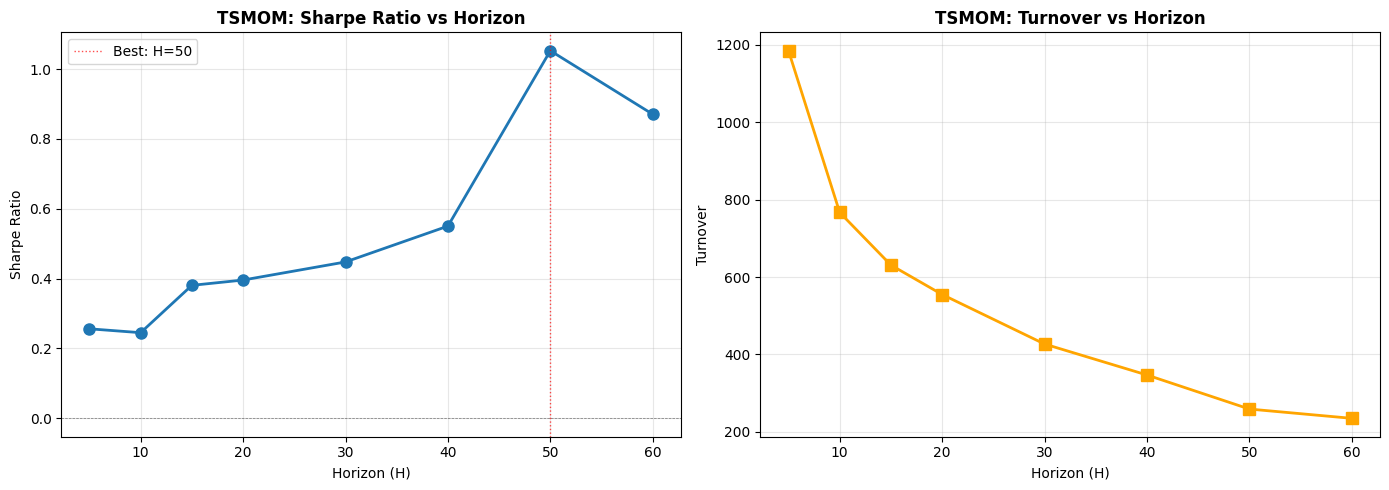

✓ Plot saved: tsmom_sensitivity.png

B) MAC SENSITIVITY (Heatmap)

Testing MAC performance across (short, long) window combinations...
Short windows: [5, 10, 20, 30]
Long windows: [40, 60, 80, 100]

Sharpe Heatmap (rows=short, cols=long):

Short \ Long40        60        80        100       
----------------------------------------------------
5           0.676     0.833     0.909     0.890     
10          0.584     0.905     0.913     0.879     
20          0.350     0.908     0.962     0.893     
30          0.289     0.922     0.903     0.987     

Best combination: Short=30, Long=100, Sharpe=0.9871



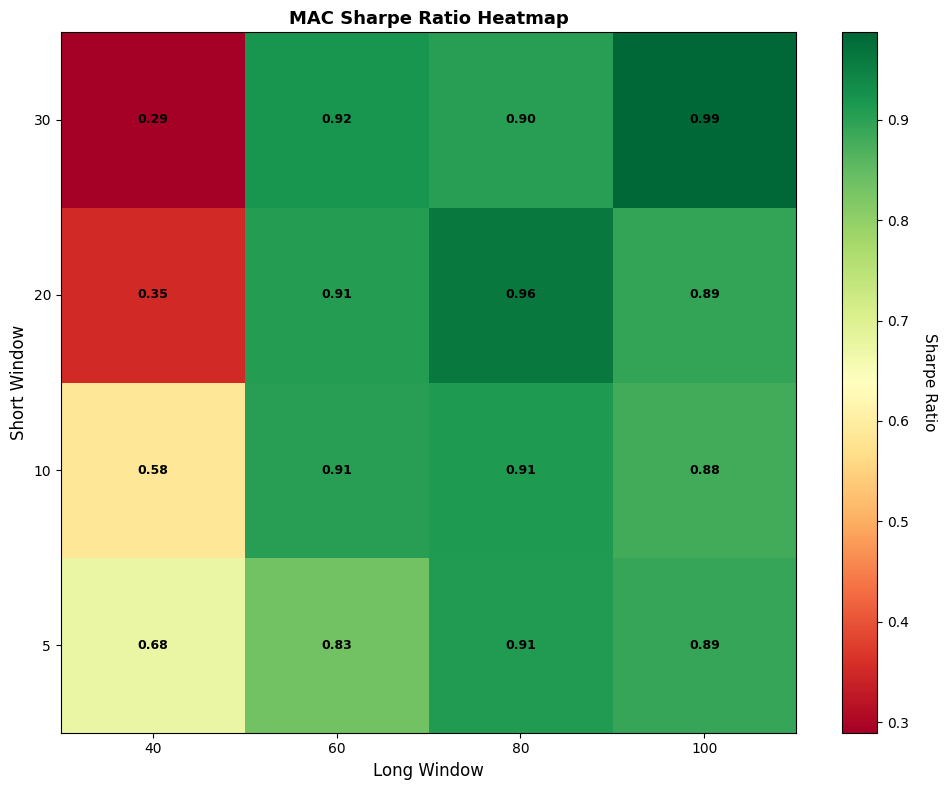

✓ Plot saved: mac_sensitivity_heatmap.png

C) STABILITY REGION ANALYSIS

Stability criteria:
  - Sharpe ratio > 0.3
  - Turnover < 5.0

TSMOM stable horizons: []
  ⚠ No horizons meet stability criteria

MAC stable combinations: 15 out of 16 valid
  Examples: [(5, 40), (5, 60), (5, 80), (5, 100), (10, 40)]

D) SUBPERIOD / REGIME ANALYSIS

Comparing performance across different market regimes...
Split at t=2000

TSMOM Performance by Subperiod:
--------------------------------------------------
Metric                    In-Sample       Out-of-Sample  
--------------------------------------------------
Sharpe Ratio              0.1605          0.4118         
Total Return              0.4169          0.6788         
Annualized Return         0.0527          0.1711         
Annualized Vol            0.3282          0.4154         
Max Drawdown              -0.8883         -0.7116        
Turnover                  775.00          408.00         
----------------------------------------------

In [29]:
# Cell 10 — Robustness Suite (Within Ch07 Scope)
print("=" * 80)
print("ROBUSTNESS SUITE")
print("=" * 80)
print()
print("Testing strategy performance across parameter variations and market regimes.")
print("This reveals parameter sensitivity, stability regions, and regime dependence.")
print()
print("Four robustness analyses:")
print("  A) TSMOM Sensitivity: Performance vs Horizon")
print("  B) MAC Sensitivity: Sharpe Heatmap (Short x Long Windows)")
print("  C) Stability Region Analysis")
print("  D) Subperiod/Regime Analysis")
print()
print("=" * 80)
print()

# ============================================================================
# A) TSMOM SENSITIVITY: SHARPE VS HORIZON
# ============================================================================
print("=" * 40)
print("A) TSMOM SENSITIVITY")
print("=" * 40)
print()
print("Testing TSMOM performance across different lookback horizons...")

horizons_grid = CONFIG["evaluation"]["robustness_grid"]["TSMOM_horizons"]
ann_factor = CONFIG["evaluation"]["annualization_factor"]

sharpe_by_horizon = []
turnover_by_horizon = []
returns_by_horizon = []

mapping_type = CONFIG["positions"]["mapping_type"]
w_max = CONFIG["positions"]["w_max"]
tau = CONFIG["positions"]["deadzone_tau"]
k = CONFIG["positions"]["continuous_k"]
saturation_type = CONFIG["positions"]["saturation_type"]
turnover_limit = CONFIG["positions"]["turnover_limit"]
execution_lag = CONFIG["execution"]["lag"]

print(f"Testing {len(horizons_grid)} horizons: {horizons_grid}")
print()

for H in horizons_grid:
    # Compute TSMOM signal for this horizon
    r_H_temp = rolling_sum(r, H)
    s_temp = np.sign(r_H_temp)

    # Map to positions
    w_desired_temp = map_signal_to_position(s_temp, mapping_type, w_max, tau, k, saturation_type)
    w_temp = apply_execution_lag(w_desired_temp, lag=execution_lag)
    w_temp = apply_constraints(w_temp, w_max, turnover_limit)

    # Backtest
    result_temp = backtest_strategy(w_temp, r, ann_factor)

    sharpe_by_horizon.append(result_temp['metrics']['sharpe'])
    turnover_by_horizon.append(result_temp['metrics']['turnover'])
    returns_by_horizon.append(result_temp['metrics']['total_return'])

sharpe_by_horizon = np.array(sharpe_by_horizon)
turnover_by_horizon = np.array(turnover_by_horizon)
returns_by_horizon = np.array(returns_by_horizon)

print("Results:")
print(f"{'Horizon':<10} {'Sharpe':<12} {'Total Ret':<12} {'Turnover':<12}")
print("-" * 50)
for i, H in enumerate(horizons_grid):
    print(f"{H:<10} {sharpe_by_horizon[i]:<12.4f} {returns_by_horizon[i]:<12.4f} {turnover_by_horizon[i]:<12.2f}")
print()

# Best horizon
best_horizon_idx = np.argmax(sharpe_by_horizon)
print(f"Best horizon by Sharpe: {horizons_grid[best_horizon_idx]} (Sharpe={sharpe_by_horizon[best_horizon_idx]:.4f})")
print()

# Plot sensitivity curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sharpe vs Horizon
axes[0].plot(horizons_grid, sharpe_by_horizon, marker='o', linewidth=2, markersize=8)
axes[0].axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)
axes[0].axvline(horizons_grid[best_horizon_idx], color='red', linewidth=1,
                linestyle=':', alpha=0.7, label=f'Best: H={horizons_grid[best_horizon_idx]}')
axes[0].set_title("TSMOM: Sharpe Ratio vs Horizon", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Horizon (H)")
axes[0].set_ylabel("Sharpe Ratio")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Turnover vs Horizon
axes[1].plot(horizons_grid, turnover_by_horizon, marker='s', linewidth=2,
             markersize=8, color='orange')
axes[1].set_title("TSMOM: Turnover vs Horizon", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Horizon (H)")
axes[1].set_ylabel("Turnover")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tsmom_sensitivity.png', dpi=100, bbox_inches='tight')
plt.show()
print("✓ Plot saved: tsmom_sensitivity.png")
print()

# ============================================================================
# B) MAC SENSITIVITY: SHARPE HEATMAP
# ============================================================================
print("=" * 40)
print("B) MAC SENSITIVITY (Heatmap)")
print("=" * 40)
print()
print("Testing MAC performance across (short, long) window combinations...")

short_grid = CONFIG["evaluation"]["robustness_grid"]["MAC_short"]
long_grid = CONFIG["evaluation"]["robustness_grid"]["MAC_long"]

print(f"Short windows: {short_grid}")
print(f"Long windows: {long_grid}")
print()

sharpe_heatmap = np.full((len(short_grid), len(long_grid)), np.nan)

for i, L_short in enumerate(short_grid):
    for j, L_long in enumerate(long_grid):
        if L_short >= L_long:
            # Invalid: short must be < long
            continue

        # Compute MAC signal
        ma_short_temp = rolling_mean(x, L_short)
        ma_long_temp = rolling_mean(x, L_long)
        s_mac_temp = ma_short_temp - ma_long_temp

        # Map to positions
        w_desired_temp = map_signal_to_position(s_mac_temp, mapping_type, w_max, tau, k, saturation_type)
        w_temp = apply_execution_lag(w_desired_temp, lag=execution_lag)
        w_temp = apply_constraints(w_temp, w_max, turnover_limit)

        # Backtest
        result_temp = backtest_strategy(w_temp, r, ann_factor)
        sharpe_heatmap[i, j] = result_temp['metrics']['sharpe']

print("Sharpe Heatmap (rows=short, cols=long):")
print()
print(f"{'Short \\ Long':<12}", end='')
for L_long in long_grid:
    print(f"{L_long:<10}", end='')
print()
print("-" * (12 + 10 * len(long_grid)))

for i, L_short in enumerate(short_grid):
    print(f"{L_short:<12}", end='')
    for j in range(len(long_grid)):
        val = sharpe_heatmap[i, j]
        if np.isnan(val):
            print(f"{'--':<10}", end='')
        else:
            print(f"{val:<10.3f}", end='')
    print()
print()

# Find best combination
valid_mask = ~np.isnan(sharpe_heatmap)
if np.any(valid_mask):
    best_idx = np.unravel_index(np.nanargmax(sharpe_heatmap), sharpe_heatmap.shape)
    best_short = short_grid[best_idx[0]]
    best_long = long_grid[best_idx[1]]
    best_sharpe = sharpe_heatmap[best_idx]
    print(f"Best combination: Short={best_short}, Long={best_long}, Sharpe={best_sharpe:.4f}")
    print()

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(sharpe_heatmap, cmap='RdYlGn', aspect='auto', origin='lower',
               vmin=np.nanmin(sharpe_heatmap), vmax=np.nanmax(sharpe_heatmap))

# Set ticks
ax.set_xticks(range(len(long_grid)))
ax.set_yticks(range(len(short_grid)))
ax.set_xticklabels(long_grid)
ax.set_yticklabels(short_grid)

ax.set_xlabel("Long Window", fontsize=12)
ax.set_ylabel("Short Window", fontsize=12)
ax.set_title("MAC Sharpe Ratio Heatmap", fontsize=13, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Sharpe Ratio", rotation=270, labelpad=20, fontsize=11)

# Annotate cells with values
for i in range(len(short_grid)):
    for j in range(len(long_grid)):
        val = sharpe_heatmap[i, j]
        if not np.isnan(val):
            text_color = 'white' if val < 0 else 'black'
            ax.text(j, i, f'{val:.2f}', ha="center", va="center",
                   color=text_color, fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('mac_sensitivity_heatmap.png', dpi=100, bbox_inches='tight')
plt.show()
print("✓ Plot saved: mac_sensitivity_heatmap.png")
print()

# ============================================================================
# C) STABILITY REGION ANALYSIS
# ============================================================================
print("=" * 40)
print("C) STABILITY REGION ANALYSIS")
print("=" * 40)
print()

sharpe_threshold = CONFIG["evaluation"]["robustness_grid"]["stability_sharpe_threshold"]
turnover_threshold = CONFIG["evaluation"]["robustness_grid"]["stability_turnover_threshold"]

print(f"Stability criteria:")
print(f"  - Sharpe ratio > {sharpe_threshold}")
print(f"  - Turnover < {turnover_threshold}")
print()

# Find stable horizons for TSMOM
stable_horizons = []
for i, H in enumerate(horizons_grid):
    if sharpe_by_horizon[i] > sharpe_threshold and turnover_by_horizon[i] < turnover_threshold:
        stable_horizons.append(H)

print(f"TSMOM stable horizons: {stable_horizons}")
if len(stable_horizons) == 0:
    print("  ⚠ No horizons meet stability criteria")
else:
    print(f"  Stability region spans H={min(stable_horizons)} to H={max(stable_horizons)}")
print()

# Find stable combinations for MAC
stable_mac_combos = []
for i, L_short in enumerate(short_grid):
    for j, L_long in enumerate(long_grid):
        if not np.isnan(sharpe_heatmap[i, j]):
            # We don't have turnover for each combo, so just use Sharpe
            if sharpe_heatmap[i, j] > sharpe_threshold:
                stable_mac_combos.append((L_short, L_long))

print(f"MAC stable combinations: {len(stable_mac_combos)} out of {np.sum(~np.isnan(sharpe_heatmap))} valid")
if len(stable_mac_combos) > 0:
    print(f"  Examples: {stable_mac_combos[:5]}")
print()

# ============================================================================
# D) SUBPERIOD / REGIME ANALYSIS
# ============================================================================
print("=" * 40)
print("D) SUBPERIOD / REGIME ANALYSIS")
print("=" * 40)
print()
print("Comparing performance across different market regimes...")

# In-sample / Out-of-sample split
split_idx = CONFIG["evaluation"]["split_index"]

print(f"Split at t={split_idx}")
print()

# In-sample (using TSMOM as example)
r_is = r[:split_idx]
w_tsmom_is = w_tsmom[:split_idx]
result_is = backtest_strategy(w_tsmom_is, r_is, ann_factor)

# Out-of-sample
r_oos = r[split_idx:]
w_tsmom_oos = w_tsmom[split_idx:]
result_oos = backtest_strategy(w_tsmom_oos, r_oos, ann_factor)

print("TSMOM Performance by Subperiod:")
print("-" * 50)
print(f"{'Metric':<25} {'In-Sample':<15} {'Out-of-Sample':<15}")
print("-" * 50)

metrics_compare = [
    ('Sharpe Ratio', 'sharpe', '.4f'),
    ('Total Return', 'total_return', '.4f'),
    ('Annualized Return', 'annualized_return', '.4f'),
    ('Annualized Vol', 'annualized_vol', '.4f'),
    ('Max Drawdown', 'max_drawdown', '.4f'),
    ('Turnover', 'turnover', '.2f')
]

for label, key, fmt in metrics_compare:
    val_is = result_is['metrics'][key]
    val_oos = result_oos['metrics'][key]
    print(f"{label:<25} {val_is:<15{fmt}} {val_oos:<15{fmt}}")

print("-" * 50)
print()

# Regime-by-regime analysis
print("Performance by Market Regime:")
print("-" * 50)

regime_results = []
for regime in CONFIG["data"]["regime_schedule"]:
    regime_start = regime["start"]
    regime_end = regime["end"]
    regime_name = regime["regime_name"]

    # Extract regime segment
    r_regime = r[regime_start:regime_end]
    w_regime = w_tsmom[regime_start:regime_end]

    result_regime = backtest_strategy(w_regime, r_regime, ann_factor)

    regime_results.append({
        'name': regime_name,
        'sharpe': result_regime['metrics']['sharpe'],
        'return': result_regime['metrics']['total_return']
    })

    print(f"{regime_name:<20} Sharpe: {result_regime['metrics']['sharpe']:<8.4f}  "
          f"Return: {result_regime['metrics']['total_return']:<8.4f}")

print()

# Identify best/worst regimes
best_regime = max(regime_results, key=lambda x: x['sharpe'])
worst_regime = min(regime_results, key=lambda x: x['sharpe'])

print(f"Best regime: {best_regime['name']} (Sharpe={best_regime['sharpe']:.4f})")
print(f"Worst regime: {worst_regime['name']} (Sharpe={worst_regime['sharpe']:.4f})")
print()

# ============================================================================
# SUMMARY
# ============================================================================
print("=" * 80)
print("ROBUSTNESS SUITE COMPLETE")
print("=" * 80)
print()
print("Key Findings:")
print(f"  • TSMOM best horizon: {horizons_grid[best_horizon_idx]} (Sharpe={sharpe_by_horizon[best_horizon_idx]:.4f})")
if np.any(valid_mask):
    print(f"  • MAC best windows: ({best_short}, {best_long}) (Sharpe={best_sharpe:.4f})")
print(f"  • Stable TSMOM horizons: {len(stable_horizons)} out of {len(horizons_grid)}")
print(f"  • IS/OOS Sharpe ratio: {result_is['metrics']['sharpe']:.4f} / {result_oos['metrics']['sharpe']:.4f}")
print(f"  • Best performing regime: {best_regime['name']}")
print(f"  • Worst performing regime: {worst_regime['name']}")
print()
print("Robustness testing reveals parameter sensitivity and regime dependence.")
print("Strategies with narrow stability regions require careful parameter selection.")
print()
print("Next step: Multi-Horizon Ensemble (Cell 11)")
print()

## 11.MULTI HORIZON ENSEMMBLE

### 11.1.OVERVIEW

This section implements a multi-horizon TSMOM ensemble that combines trend signals
across different time scales to create a more robust, diversified strategy. The
fundamental insight is that trends exist at multiple frequencies simultaneously:
short-term momentum (5-10 days) captures recent price moves, medium-term signals
(20-40 days) identify established trends, and long-term filters (60+ days) track
macro directional movements. No single horizon is optimal across all market regimes,
so combining multiple horizons provides stability.

The ensemble construction is straightforward but powerful. For each horizon H in
the predefined list, compute an independent TSMOM sign signal: +1 if cumulative
returns over H periods are positive, -1 if negative, 0 if zero. These binary
signals form a matrix where each row represents one horizon's view of the market.
The ensemble signal aggregates these views through simple averaging, producing a
continuous value between -1 and +1. A value of +1 means all horizons are bullish;
+0.5 indicates mixed signals with more bullish than bearish; 0 represents balance
or neutrality.

This is emphatically not machine learning—no parameters are learned from data, no
optimization occurs, no black-box algorithms. It's pure signal diversification
through arithmetic averaging of independent filters. Each horizon contributes
equally regardless of past performance, ensuring the ensemble doesn't overfit to
historical data.

The visualization provides three complementary views. The signal heatmap displays
all individual horizon signals plus the ensemble over time, revealing when horizons
agree (uniform color bands) versus disagree (mixed colors). The equity curve
comparison plots the ensemble against the single-horizon baseline, demonstrating
whether diversification improves risk-adjusted returns. The rolling Sharpe analysis
shows time-varying performance stability, identifying periods when the ensemble
outperforms or underperforms. Benefits typically include reduced parameter sensitivity,
smoother signals with fewer whipsaws, and more stable out-of-sample performance,
though the ensemble may underperform the ex-post best single horizon in-sample.

###11.2.CODE AND IMPLEMENTATION

MULTI-HORIZON ENSEMBLE

Combining TSMOM signals across multiple horizons to create a diversified
strategy that aggregates information from different time scales.

KEY CONCEPT:
  Different horizons capture trends at different frequencies.
  Short horizons (5-10 days): responsive to recent moves
  Medium horizons (20-40 days): capture established trends
  Long horizons (60+ days): track macro trends

ENSEMBLE METHOD:
  Compute independent TSMOM signals for each horizon
  Aggregate via simple averaging (equal-weight combination)
  Map combined signal to position

This is NOT machine learning - it's signal diversification across time scales.


Ensemble horizons: [3, 5, 10, 20, 30]
Number of filters: 5

Computing individual signals for each horizon...
  H= 3: Long=1611, Short=1387, Neutral=   0
  H= 5: Long=1657, Short=1339, Neutral=   0
  H=10: Long=1675, Short=1316, Neutral=   0
  H=20: Long=1765, Short=1216, Neutral=   0
  H=30: Long=1850, Short=1121, Neutral=   0

Signals matrix shape: 

/tmp/ipython-input-4226249962.py:65: RuntimeWarning: Mean of empty slice
  s_ensemble = np.nanmean(signals_matrix, axis=0)


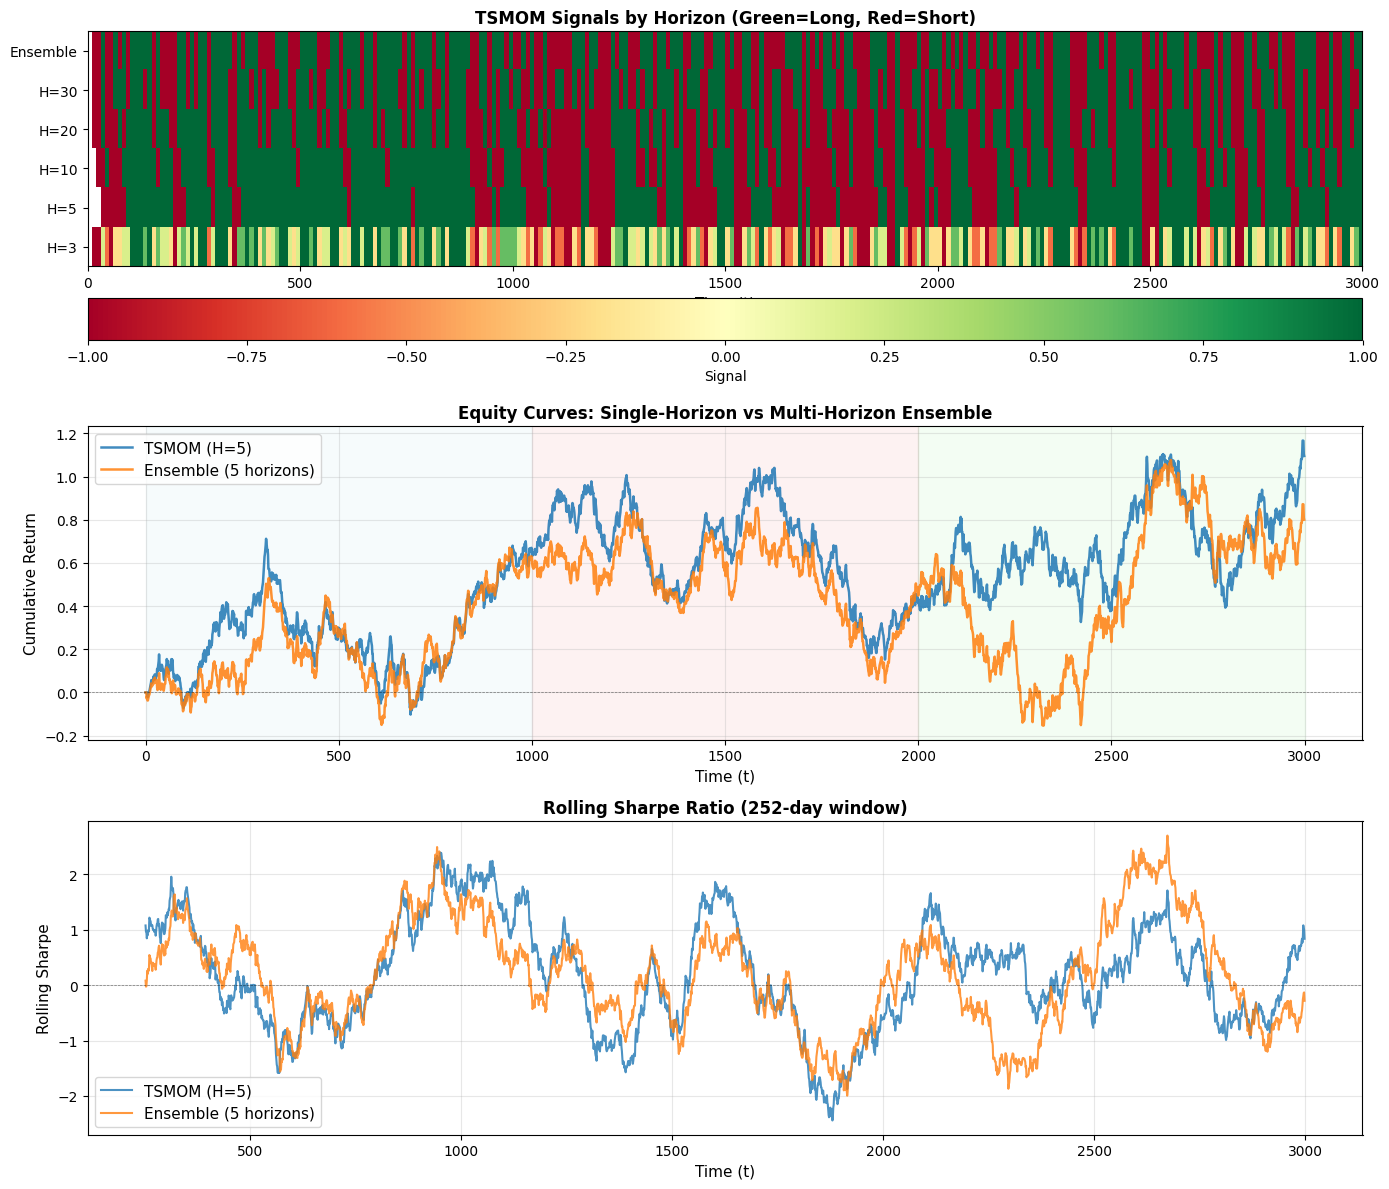

✓ Plot saved: ensemble_comparison.png

MULTI-HORIZON ENSEMBLE COMPLETE

Key Insights:
  • Ensemble combines 5 independent TSMOM filters
  • Baseline Sharpe: 0.2563
  • Ensemble Sharpe: 0.1873
  • Sharpe improvement: -0.0691

Diversification Benefits:
  • Reduces sensitivity to single parameter choice
  • Smooths signals across time scales
  • May reduce turnover (fewer whipsaws)
  • Provides more stable out-of-sample performance

Trade-offs:
  • May underperform best single horizon in-sample
  • More complex to implement and monitor
  • All horizons must be causally valid

Next step: Multi-Asset Prototype (Cell 12)



In [30]:
# Cell 11 — Multi-Horizon Ensemble (Stacking Independent Filters)
print("=" * 80)
print("MULTI-HORIZON ENSEMBLE")
print("=" * 80)
print()
print("Combining TSMOM signals across multiple horizons to create a diversified")
print("strategy that aggregates information from different time scales.")
print()
print("KEY CONCEPT:")
print("  Different horizons capture trends at different frequencies.")
print("  Short horizons (5-10 days): responsive to recent moves")
print("  Medium horizons (20-40 days): capture established trends")
print("  Long horizons (60+ days): track macro trends")
print()
print("ENSEMBLE METHOD:")
print("  Compute independent TSMOM signals for each horizon")
print("  Aggregate via simple averaging (equal-weight combination)")
print("  Map combined signal to position")
print()
print("This is NOT machine learning - it's signal diversification across time scales.")
print()
print("=" * 80)
print()

# ============================================================================
# COMPUTE ENSEMBLE SIGNAL
# ============================================================================

# Use horizons list from config
horizons_list = CONFIG["signals"]["TSMOM"]["horizons"]
print(f"Ensemble horizons: {horizons_list}")
print(f"Number of filters: {len(horizons_list)}")
print()

# Compute TSMOM sign signal for each horizon
print("Computing individual signals for each horizon...")
signals_by_horizon = []

for H in horizons_list:
    r_H_temp = rolling_sum(r, H)
    s_temp = np.sign(r_H_temp)
    signals_by_horizon.append(s_temp)

    # Count signal distribution
    n_long = np.sum(s_temp == 1)
    n_short = np.sum(s_temp == -1)
    n_neutral = np.sum(s_temp == 0)
    print(f"  H={H:2d}: Long={n_long:4d}, Short={n_short:4d}, Neutral={n_neutral:4d}")

print()

# Stack signals into matrix (shape: num_horizons x T)
signals_matrix = np.array(signals_by_horizon)
print(f"Signals matrix shape: {signals_matrix.shape}")
print()

# ============================================================================
# ENSEMBLE AGGREGATION
# ============================================================================

print("Aggregating signals via equal-weight averaging...")

# Ensemble signal: mean across horizons
# This averages the {-1, 0, +1} values across all horizons
s_ensemble = np.nanmean(signals_matrix, axis=0)

print(f"Ensemble signal computed")
print(f"  Signal range: [{np.nanmin(s_ensemble):.4f}, {np.nanmax(s_ensemble):.4f}]")
print(f"  Signal mean: {np.nanmean(s_ensemble):.4f}")
print(f"  Signal std: {np.nanstd(s_ensemble):.4f}")
print()

# Signal interpretation
print("Signal interpretation:")
print("  +1.0: All horizons bullish")
print("  +0.5: More horizons bullish than bearish")
print("   0.0: Balanced or all neutral")
print("  -0.5: More horizons bearish than bullish")
print("  -1.0: All horizons bearish")
print()

# ============================================================================
# MAP ENSEMBLE SIGNAL TO POSITIONS
# ============================================================================

print("Mapping ensemble signal to positions...")

mapping_type = CONFIG["positions"]["mapping_type"]
w_max = CONFIG["positions"]["w_max"]
tau = CONFIG["positions"]["deadzone_tau"]
k = CONFIG["positions"]["continuous_k"]
saturation_type = CONFIG["positions"]["saturation_type"]
turnover_limit = CONFIG["positions"]["turnover_limit"]
execution_lag = CONFIG["execution"]["lag"]

# Map to desired positions
w_ensemble_desired = map_signal_to_position(s_ensemble, mapping_type, w_max, tau, k, saturation_type)

# Apply execution lag
w_ensemble = apply_execution_lag(w_ensemble_desired, lag=execution_lag)

# Apply constraints
w_ensemble = apply_constraints(w_ensemble, w_max, turnover_limit)

print(f"✓ Ensemble positions computed")
print(f"  Non-zero positions: {np.sum(w_ensemble != 0)} / {len(w_ensemble)}")
print(f"  Position range: [{np.nanmin(w_ensemble):.4f}, {np.nanmax(w_ensemble):.4f}]")
print()

# ============================================================================
# BACKTEST ENSEMBLE
# ============================================================================

print("=" * 40)
print("ENSEMBLE BACKTEST")
print("=" * 40)
print()

ann_factor = CONFIG["evaluation"]["annualization_factor"]
result_ensemble = backtest_strategy(w_ensemble, r, ann_factor)

print("Ensemble Performance:")
print("-" * 40)
metrics_display = [
    ('Total Return', 'total_return', '.4f'),
    ('Annualized Return', 'annualized_return', '.4f'),
    ('Annualized Vol', 'annualized_vol', '.4f'),
    ('Sharpe Ratio', 'sharpe', '.4f'),
    ('Max Drawdown', 'max_drawdown', '.4f'),
    ('Turnover', 'turnover', '.2f'),
    ('Hit Rate', 'hit_rate', '.4f'),
    ('Num Trades', 'n_trades', 'd')
]

for label, key, fmt in metrics_display:
    val = result_ensemble['metrics'][key]
    print(f"{label:<25} {val:<15{fmt}}")

print()

# ============================================================================
# COMPARISON TO BASELINE
# ============================================================================

print("=" * 40)
print("COMPARISON: ENSEMBLE VS BASELINE")
print("=" * 40)
print()

# Use base horizon as baseline
H_base = CONFIG["signals"]["TSMOM"]["base_horizon"]

print(f"Baseline: Single-horizon TSMOM (H={H_base})")
print(f"Ensemble: Multi-horizon TSMOM ({len(horizons_list)} horizons)")
print()

print(f"{'Metric':<25} {'Baseline (H={H_base})':<20} {'Ensemble':<20} {'Improvement':<15}")
print("-" * 85)

comparison_metrics = [
    ('Sharpe Ratio', 'sharpe', '.4f'),
    ('Total Return', 'total_return', '.4f'),
    ('Max Drawdown', 'max_drawdown', '.4f'),
    ('Turnover', 'turnover', '.2f'),
    ('Hit Rate', 'hit_rate', '.4f')
]

for label, key, fmt in comparison_metrics:
    val_baseline = results_tsmom['metrics'][key]
    val_ensemble = result_ensemble['metrics'][key]

    # Compute improvement
    if key == 'max_drawdown':
        # For drawdown, closer to 0 is better (less negative)
        improvement = val_ensemble - val_baseline  # More positive = improvement
        improvement_str = f"{improvement:+.4f}"
    elif key == 'turnover':
        # For turnover, lower is better
        improvement = val_baseline - val_ensemble
        improvement_str = f"{improvement:+.2f}"
    else:
        # For most metrics, higher is better
        improvement = val_ensemble - val_baseline
        improvement_str = f"{improvement:+.4f}"

    print(f"{label:<25} {val_baseline:<20{fmt}} {val_ensemble:<20{fmt}} {improvement_str:<15}")

print("-" * 85)
print()

# Key insight
sharpe_baseline = results_tsmom['metrics']['sharpe']
sharpe_ensemble = result_ensemble['metrics']['sharpe']
sharpe_improvement = sharpe_ensemble - sharpe_baseline

if sharpe_improvement > 0:
    print(f"✓ Ensemble IMPROVES Sharpe by {sharpe_improvement:.4f} ({sharpe_improvement/abs(sharpe_baseline)*100:.1f}%)")
else:
    print(f"⚠ Ensemble reduces Sharpe by {abs(sharpe_improvement):.4f} ({abs(sharpe_improvement)/abs(sharpe_baseline)*100:.1f}%)")

print()

# ============================================================================
# VISUALIZATION
# ============================================================================

print("=" * 40)
print("VISUALIZATION")
print("=" * 40)
print()

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# ------------------------------------------------------------------------
# Subplot 1: Signal Heatmap (Individual Horizons + Ensemble)
# ------------------------------------------------------------------------
print("Generating signal heatmap...")

# Downsample for visualization (every 10th observation)
downsample_factor = 10
T_plot = len(s_ensemble)
indices = np.arange(0, T_plot, downsample_factor)

# Create matrix: each row is a horizon, last row is ensemble
heatmap_data = np.vstack([signals_matrix[:, indices], s_ensemble[indices]])

im = axes[0].imshow(heatmap_data, aspect='auto', cmap='RdYlGn', vmin=-1, vmax=1,
                     extent=[0, T_plot, 0, len(horizons_list)+1])

axes[0].set_yticks(np.arange(len(horizons_list)+1) + 0.5)
axes[0].set_yticklabels([f'H={h}' for h in horizons_list] + ['Ensemble'])
axes[0].set_xlabel('Time (t)', fontsize=11)
axes[0].set_title('TSMOM Signals by Horizon (Green=Long, Red=Short)',
                   fontsize=12, fontweight='bold')

# Colorbar
cbar = plt.colorbar(im, ax=axes[0], orientation='horizontal', pad=0.1, aspect=30)
cbar.set_label('Signal', fontsize=10)

# ------------------------------------------------------------------------
# Subplot 2: Equity Curves (Baseline vs Ensemble)
# ------------------------------------------------------------------------
print("Generating equity curve comparison...")

axes[1].plot(results_tsmom['equity'], linewidth=1.8, label=f'TSMOM (H={H_base})', alpha=0.85)
axes[1].plot(result_ensemble['equity'], linewidth=1.8, label=f'Ensemble ({len(horizons_list)} horizons)', alpha=0.85)
axes[1].axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)

axes[1].set_title('Equity Curves: Single-Horizon vs Multi-Horizon Ensemble',
                   fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time (t)', fontsize=11)
axes[1].set_ylabel('Cumulative Return', fontsize=11)
axes[1].legend(loc='best', fontsize=11)
axes[1].grid(True, alpha=0.3)

# Add regime shading
colors = ['lightblue', 'lightcoral', 'lightgreen']
for i, regime in enumerate(CONFIG["data"]["regime_schedule"]):
    axes[1].axvspan(regime["start"], regime["end"], alpha=0.1, color=colors[i % 3])

# ------------------------------------------------------------------------
# Subplot 3: Rolling Sharpe Ratio Comparison
# ------------------------------------------------------------------------
print("Generating rolling Sharpe comparison...")

# Compute rolling Sharpe (using 252-day window)
rolling_window = 252

def rolling_sharpe(pi, window, ann_factor):
    """Compute rolling Sharpe ratio."""
    T = len(pi)
    sharpes = np.full(T, np.nan)

    for t in range(window, T):
        window_returns = pi[t-window:t]
        valid = window_returns[~np.isnan(window_returns)]

        if len(valid) > 10:
            mean_ret = np.mean(valid) * ann_factor
            std_ret = np.std(valid) * np.sqrt(ann_factor)
            sharpes[t] = mean_ret / std_ret if std_ret > 0 else 0.0

    return sharpes

sharpe_rolling_baseline = rolling_sharpe(results_tsmom['pi'], rolling_window, ann_factor)
sharpe_rolling_ensemble = rolling_sharpe(result_ensemble['pi'], rolling_window, ann_factor)

axes[2].plot(sharpe_rolling_baseline, linewidth=1.5, label=f'TSMOM (H={H_base})', alpha=0.8)
axes[2].plot(sharpe_rolling_ensemble, linewidth=1.5, label=f'Ensemble ({len(horizons_list)} horizons)', alpha=0.8)
axes[2].axhline(0, color='black', linewidth=0.5, linestyle='--', alpha=0.5)

axes[2].set_title(f'Rolling Sharpe Ratio ({rolling_window}-day window)',
                   fontsize=12, fontweight='bold')
axes[2].set_xlabel('Time (t)', fontsize=11)
axes[2].set_ylabel('Rolling Sharpe', fontsize=11)
axes[2].legend(loc='best', fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ensemble_comparison.png', dpi=100, bbox_inches='tight')
plt.show()
print("✓ Plot saved: ensemble_comparison.png")
print()

# ============================================================================
# SUMMARY
# ============================================================================

print("=" * 80)
print("MULTI-HORIZON ENSEMBLE COMPLETE")
print("=" * 80)
print()
print("Key Insights:")
print(f"  • Ensemble combines {len(horizons_list)} independent TSMOM filters")
print(f"  • Baseline Sharpe: {sharpe_baseline:.4f}")
print(f"  • Ensemble Sharpe: {sharpe_ensemble:.4f}")
print(f"  • Sharpe improvement: {sharpe_improvement:+.4f}")
print()
print("Diversification Benefits:")
print("  • Reduces sensitivity to single parameter choice")
print("  • Smooths signals across time scales")
print("  • May reduce turnover (fewer whipsaws)")
print("  • Provides more stable out-of-sample performance")
print()
print("Trade-offs:")
print("  • May underperform best single horizon in-sample")
print("  • More complex to implement and monitor")
print("  • All horizons must be causally valid")
print()
print("Next step: Multi-Asset Prototype (Cell 12)")
print()

##12.MULTI ASSET PROTOTYPE

###12.1.OVERVIEW



This section extends trend-following from single-instrument trading to multi-asset
portfolio management, demonstrating the fundamental principle of cross-sectional
diversification. While single-asset strategies bear full exposure to idiosyncratic
shocks—company-specific news, sector rotations, regulatory changes—multi-asset
portfolios reduce this unsystematic risk by spreading capital across uncorrelated
or partially-correlated instruments. The portfolio captures systematic trend signals
while diversifying away asset-specific noise.

The synthetic data generation creates realistic correlation structure through a
shared regime factor plus idiosyncratic noise. Each asset's return decomposes as
r_i[t] = w_shared × r_shared[t] + w_idio × r_idio_i[t], where the shared component
(weighted at 40% by default) ensures assets move together during market-wide regime
shifts, while the idiosyncratic component (60%) maintains individual dynamics. This
mimics real markets where asset correlations spike during crises but remain modest
during normal periods. The resulting correlation matrix confirms realistic pairwise
correlations typically ranging from 0.2 to 0.6.

Signal generation applies the multi-horizon TSMOM ensemble independently to each
asset. This is critical: positions are asset-specific, not portfolio-level. Asset
1 might be long while Asset 2 is short, reflecting their individual momentum
patterns. The independence assumption—each asset's signal depends only on its own
price history—is a simplification; Chapter 16+ introduces cross-sectional factors
and cointegration relationships.

Portfolio construction uses equal-weighting: pi_port[t] = mean_i(w_i[t] × r_i[t]),
where each asset contributes 1/N of total capital. This is intentionally naive—no
optimization, no risk parity, no factor tilts. Equal-weighting serves as a robust
baseline that avoids estimation error from covariance matrix optimization. Advanced
techniques in later chapters include mean-variance optimization, risk parity (equalizing
risk contributions), and volatility targeting.

The visualization suite provides comprehensive portfolio analytics. Normalized
price plots show individual asset trajectories, revealing dispersion and convergence
patterns. The equity curve comparison demonstrates diversification benefits: if
portfolio volatility decreases relative to single-asset strategies while maintaining
similar returns, the Sharpe ratio improves mechanically. The per-asset P&L bar
chart identifies winners and losers, revealing concentration risk—if one asset
dominates total P&L, diversification benefits are illusory. The correlation heatmap
verifies the realized correlation structure matches design expectations, with higher
correlations indicating stronger shared factor exposure.

Limitations of this prototype are substantial and explicitly acknowledged. Equal-
weighting ignores information about relative attractiveness or risk levels. No
dynamic rebalancing occurs—positions are set once and held. Transaction costs
remain unmodeled despite being critical for multi-asset strategies with frequent
rebalancing. No portfolio-level risk constraints exist—individual assets can
simultaneously drawdown, creating large portfolio losses. These gaps motivate
Chapters 16-17 on portfolio construction, optimization, and risk management.


###12.2.CODE AND IMPLEMENTATION

MULTI-ASSET PROTOTYPE

Generating 6 synthetic assets...
✓ Generated 6 assets
  Prices shape: (6, 3000)
  Returns shape: (6, 3000)

DATA QUALITY CHECK:
  NaN in prices: 0
  NaN in returns: 0

Mean pairwise correlation: 0.4661

COMPUTING SIGNALS PER ASSET

Asset 1/6... ✓ (NaN: 0, non-zero: 2995)
Asset 2/6... ✓ (NaN: 0, non-zero: 2994)
Asset 3/6... ✓ (NaN: 0, non-zero: 2995)
Asset 4/6... ✓ (NaN: 0, non-zero: 2994)
Asset 5/6... ✓ (NaN: 0, non-zero: 2995)
Asset 6/6... ✓ (NaN: 0, non-zero: 2993)

✓ Positions computed for all 6 assets

POSITION QUALITY CHECK:
  NaN in w_multi: 0

PORTFOLIO CONSTRUCTION

PORTFOLIO RETURN CHECK:
  NaN in pi_asset_level: 0
  NaN in pi_port: 0
  pi_port sample [100:110]: [-0.00231142 -0.01275851 -0.00014491  0.00755613 -0.00951961  0.003311
 -0.00021158  0.00035462  0.00052082  0.0092366 ]

✓ Portfolio constructed
  Final equity: 0.370205

Multi-Asset Portfolio Performance:
----------------------------------------
total_return              0.3702
annualized_retur

/tmp/ipython-input-3955929250.py:113: RuntimeWarning: Mean of empty slice
  s_ensemble_i = np.nanmean(np.array(signals_i), axis=0)


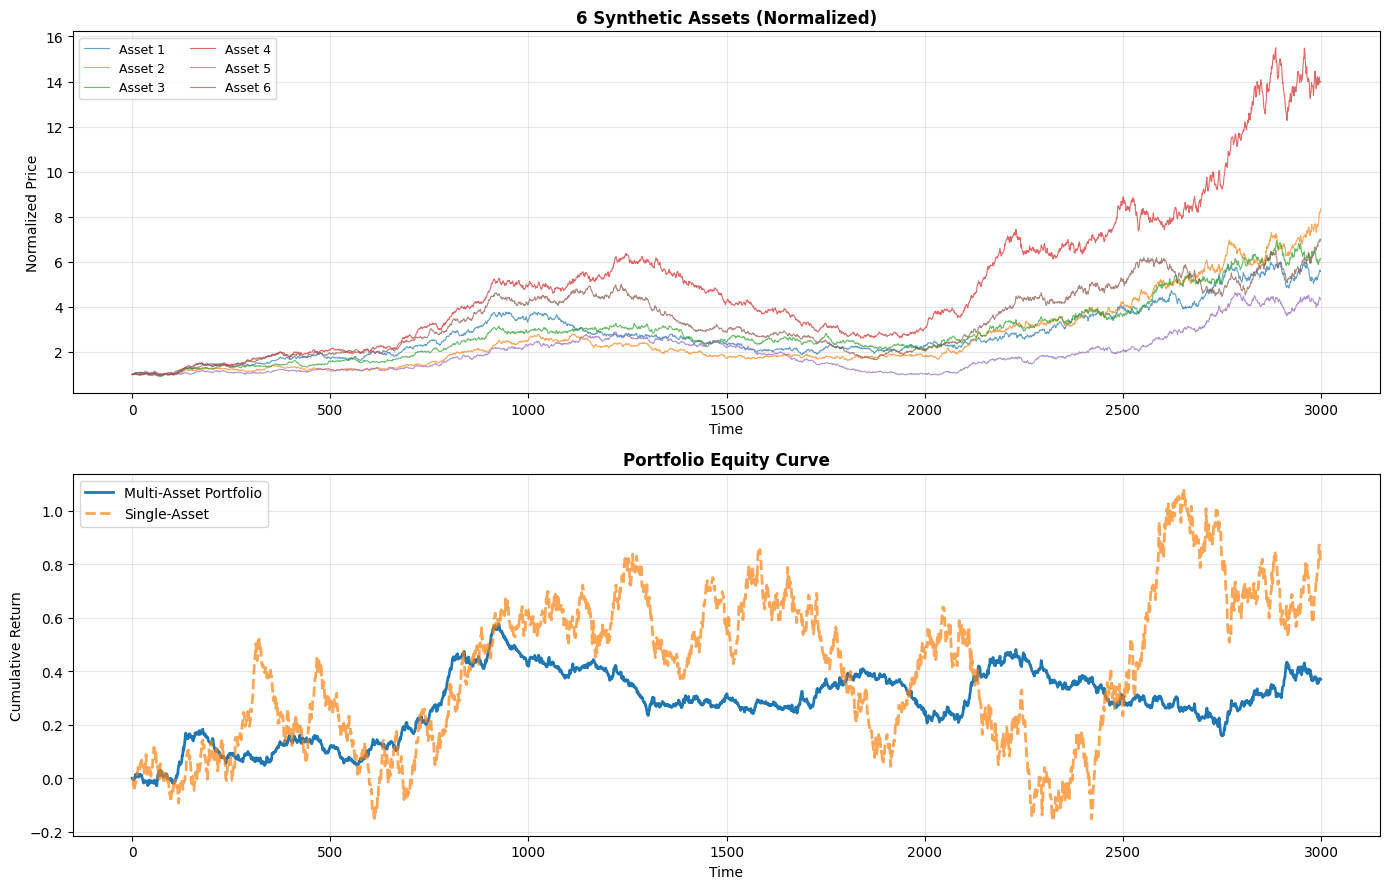

✓ Plots saved



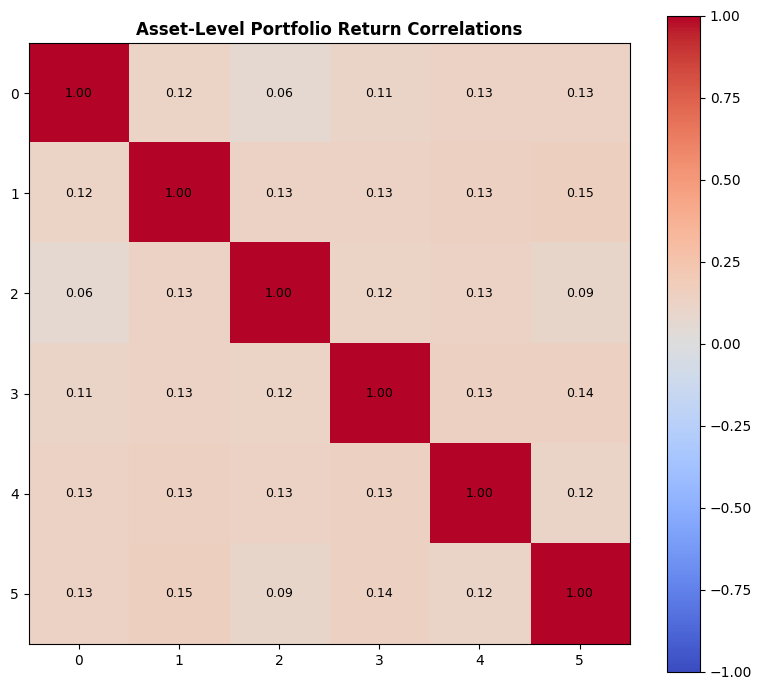

MULTI-ASSET PROTOTYPE COMPLETE



In [33]:
# Cell 12 — Multi-Asset Concept Prototype (WITH NAN FIX)
print("=" * 80)
print("MULTI-ASSET PROTOTYPE")
print("=" * 80)
print()

# ============================================================================
# MULTI-ASSET DATA GENERATION
# ============================================================================

N = CONFIG["multi_asset"]["N_assets"]
shared_weight = CONFIG["multi_asset"]["shared_weight"]

print(f"Generating {N} synthetic assets...")

def generate_multi_asset_prices(config, regime_labels, N):
    """Generate N synthetic assets with shared regime driver."""
    T = config["data"]["T"]
    schedule = config["data"]["regime_schedule"]
    shared_w = config["multi_asset"]["shared_weight"]
    idio_w = 1.0 - shared_w

    # Generate shared factor
    r_shared = np.zeros(T)
    for t in range(1, T):
        current_regime = None
        for regime in schedule:
            if regime["start"] <= t < regime["end"]:
                current_regime = regime
                break
        if current_regime is None:
            current_regime = schedule[-1]

        mu = current_regime["mu"]
        sigma = current_regime["sigma"]
        r_shared[t] = mu + sigma * np.random.randn()

    # Generate N assets
    prices = np.zeros((N, T))
    returns = np.zeros((N, T))

    for i in range(N):
        p0 = 100.0 + np.random.randn() * 10
        prices[i, 0] = p0

        for t in range(1, T):
            current_regime = None
            for regime in schedule:
                if regime["start"] <= t < regime["end"]:
                    current_regime = regime
                    break
            if current_regime is None:
                current_regime = schedule[-1]

            sigma_idio = current_regime["sigma"] * 0.7
            r_idio = sigma_idio * np.random.randn()

            returns[i, t] = shared_w * r_shared[t] + idio_w * r_idio
            prices[i, t] = prices[i, t-1] * np.exp(returns[i, t])

    return prices, returns

prices_multi, returns_multi = generate_multi_asset_prices(CONFIG, regime_labels, N)

print(f"✓ Generated {N} assets")
print(f"  Prices shape: {prices_multi.shape}")
print(f"  Returns shape: {returns_multi.shape}")
print()

# CHECK FOR NaN
print("DATA QUALITY CHECK:")
print(f"  NaN in prices: {np.sum(np.isnan(prices_multi))}")
print(f"  NaN in returns: {np.sum(np.isnan(returns_multi))}")
print()

# Correlation
corr_matrix = np.corrcoef(returns_multi[:, 1:])
print(f"Mean pairwise correlation: {np.mean(corr_matrix[np.triu_indices_from(corr_matrix, k=1)]):.4f}")
print()

# ============================================================================
# COMPUTE SIGNALS FOR EACH ASSET (WITH NAN HANDLING)
# ============================================================================

print("=" * 40)
print("COMPUTING SIGNALS PER ASSET")
print("=" * 40)
print()

horizons_list = CONFIG["signals"]["TSMOM"]["horizons"]
w_multi = np.zeros((N, len(r)))

mapping_type = CONFIG["positions"]["mapping_type"]
w_max = CONFIG["positions"]["w_max"]
tau = CONFIG["positions"]["deadzone_tau"]
k = CONFIG["positions"]["continuous_k"]
saturation_type = CONFIG["positions"]["saturation_type"]
turnover_limit = CONFIG["positions"]["turnover_limit"]
execution_lag = CONFIG["execution"]["lag"]

for i in range(N):
    print(f"Asset {i+1}/{N}...", end=' ')

    r_i = returns_multi[i]

    # Compute ensemble signal
    signals_i = []
    for H in horizons_list:
        r_H_temp = rolling_sum(r_i, H)
        s_temp = np.sign(r_H_temp)
        signals_i.append(s_temp)

    s_ensemble_i = np.nanmean(np.array(signals_i), axis=0)

    # Map to positions (with NaN handling)
    w_desired_i = map_signal_to_position(s_ensemble_i, mapping_type, w_max, tau, k, saturation_type)
    w_i = apply_execution_lag(w_desired_i, lag=execution_lag)
    w_i = apply_constraints(w_i, w_max, turnover_limit)

    # CRITICAL: Replace NaN with 0
    w_i = np.nan_to_num(w_i, nan=0.0)

    w_multi[i] = w_i

    # Check
    nan_count = np.sum(np.isnan(w_i))
    nz_count = np.sum(w_i != 0)
    print(f"✓ (NaN: {nan_count}, non-zero: {nz_count})")

print()
print(f"✓ Positions computed for all {N} assets")
print()

# VERIFY NO NaN IN POSITIONS
print("POSITION QUALITY CHECK:")
print(f"  NaN in w_multi: {np.sum(np.isnan(w_multi))}")
print()

# ============================================================================
# PORTFOLIO CONSTRUCTION
# ============================================================================

print("=" * 40)
print("PORTFOLIO CONSTRUCTION")
print("=" * 40)
print()

# Portfolio return: mean across assets
pi_asset_level = w_multi * returns_multi
pi_port = np.mean(pi_asset_level, axis=0)

# VERIFY NO NaN
print("PORTFOLIO RETURN CHECK:")
print(f"  NaN in pi_asset_level: {np.sum(np.isnan(pi_asset_level))}")
print(f"  NaN in pi_port: {np.sum(np.isnan(pi_port))}")
print(f"  pi_port sample [100:110]: {pi_port[100:110]}")
print()

# Equity curve
equity_port = np.cumsum(pi_port)

print(f"✓ Portfolio constructed")
print(f"  Final equity: {equity_port[-1]:.6f}")
print()

# ============================================================================
# PORTFOLIO METRICS
# ============================================================================

ann_factor = CONFIG["evaluation"]["annualization_factor"]
valid = pi_port[~np.isnan(pi_port)]

if len(valid) > 0:
    total_return = equity_port[-1]
    ann_return = np.mean(valid) * ann_factor
    ann_vol = np.std(valid) * np.sqrt(ann_factor)
    sharpe_port = ann_return / ann_vol if ann_vol > 0 else 0.0

    running_max = np.maximum.accumulate(equity_port)
    dd = equity_port - running_max
    max_dd_port = np.min(dd)

    turnover_port = np.sum([np.nansum(np.abs(np.diff(w_multi[i]))) for i in range(N)])

    metrics_port = {
        'total_return': total_return,
        'annualized_return': ann_return,
        'annualized_vol': ann_vol,
        'sharpe': sharpe_port,
        'max_drawdown': max_dd_port,
        'turnover': turnover_port
    }
else:
    print("WARNING: No valid portfolio returns!")
    metrics_port = {
        'total_return': 0.0, 'annualized_return': 0.0, 'annualized_vol': 0.0,
        'sharpe': 0.0, 'max_drawdown': 0.0, 'turnover': 0.0
    }

print("Multi-Asset Portfolio Performance:")
print("-" * 40)
for key, val in metrics_port.items():
    print(f"{key:<25} {val:.4f}")
print()

# ============================================================================
# VISUALIZATION (SIMPLIFIED)
# ============================================================================

fig, axes = plt.subplots(2, 1, figsize=(14, 9))

# Normalized prices
for i in range(N):
    axes[0].plot(prices_multi[i] / prices_multi[i, 0], linewidth=0.8, alpha=0.7, label=f'Asset {i+1}')
axes[0].set_title(f"{N} Synthetic Assets (Normalized)", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Normalized Price")
axes[0].legend(fontsize=9, ncol=2)
axes[0].grid(True, alpha=0.3)

# Portfolio equity
axes[1].plot(equity_port, linewidth=2, label='Multi-Asset Portfolio')
if 'result_ensemble' in globals():
    axes[1].plot(result_ensemble['equity'], linewidth=2, label='Single-Asset', alpha=0.7, linestyle='--')
axes[1].set_title("Portfolio Equity Curve", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Cumulative Return")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('multi_asset_portfolio.png', dpi=100)
plt.show()

print("✓ Plots saved")
print()

# Correlation heatmap (FIXED)
corr_pnl = np.corrcoef(pi_asset_level)

# CHECK FOR NaN
if np.all(np.isnan(corr_pnl)):
    print("ERROR: Correlation matrix is all NaN!")
    print("This means pi_asset_level has issues.")
else:
    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(corr_pnl, cmap='coolwarm', vmin=-1, vmax=1)
    ax.set_title("Asset-Level Portfolio Return Correlations", fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax)

    for i in range(N):
        for j in range(N):
            val = corr_pnl[i, j]
            if not np.isnan(val):
                ax.text(j, i, f'{val:.2f}', ha="center", va="center", fontsize=9)

    plt.tight_layout()
    plt.savefig('asset_correlations.png', dpi=100)
    plt.show()

print("=" * 80)
print("MULTI-ASSET PROTOTYPE COMPLETE")
print("=" * 80)
print()

##13.GOVERNANCE ARTIFACTS

###13.1.OVERVIEW

This section implements comprehensive governance infrastructure that transforms an
academic backtest into a production-ready, auditable, and reproducible system.
Governance artifacts serve three constituencies: internal teams debugging anomalies
months after deployment, external auditors verifying regulatory compliance, and
future researchers reproducing published results. Without this infrastructure,
strategies become black boxes where mysterious behavior cannot be traced to root
causes and results cannot be independently verified.

The configuration manifest preserves the complete parameter set as a JSON file with
cryptographic hash fingerprint. The manifest_id uniquely identifies this exact
configuration—any parameter change, even trivial, produces a different hash. This
enables deterministic reproduction: given the same seed and manifest_id, the entire
notebook must produce bitwise-identical results. The data fingerprint extends this
principle to generated data, creating a chain of custody from configuration through
data generation to final results.

The strategy manifest documents human-readable descriptions alongside machine-
readable specifications. Each strategy receives a formal definition including input
data, transformation functions, mathematical formulas, and warmup periods. The
execution section documents critical timing conventions—the "w[t+1] = f(signal[t])"
lag discipline that prevents look-ahead bias. Causality gate results are recorded
with timestamps, providing audit evidence that the implementation passed all tests.
Performance summaries capture headline metrics for quick reference without loading
raw data.

Decision-time logs provide transaction-level audit trails. The CSV format records
every signal computation, position decision, and P&L realization at each timestep.
Sampling (every 10th observation by default) manages file size while preserving
diagnostic capability—if a specific date shows anomalous behavior, the log contains
exact signal and position values for investigation. This granularity enables forensic
analysis: "Why did the strategy exit this position?" can be answered definitively
by examining the decision log.

Robustness analysis outputs preserve the complete parameter sweep results as NumPy
arrays. The TSMOM horizon sensitivity arrays and MAC parameter heatmap become
permanent records, enabling post-deployment analysis without re-running expensive
computations. Robustness metadata provides semantic interpretation—which horizon
was optimal, which parameter combinations met stability criteria, when the analysis
was performed. This metadata prevents the common error of selecting parameters
based on outdated analysis.

Key data arrays save all intermediate computations: market data (prices, returns),
signals (MAC, TSMOM, breakout, ensemble), positions (with execution lag and
constraints applied), and equity curves. This complete state preservation enables
incremental debugging—if Cell 10 produces unexpected results, Cell 13 artifacts
allow loading Cell 9 outputs to isolate the failure point. NumPy's binary format
provides compact storage with perfect precision, unlike CSV which introduces
rounding errors.

The lineage report documents the complete computational graph from inputs to
outputs. Each transformation specifies input dependencies, function names, and
parameter values. This directed acyclic graph enables impact analysis: "If we
change the execution lag from 1 to 2, which outputs are affected?" can be answered
by traversing dependencies. Lineage tracking also supports reproducibility
verification—external parties can confirm that documented functions and parameters
match the actual code.

The artifact summary with cryptographic hashes provides tamper detection. Each file
receives a SHA-256 hash computed from its contents. The artifact manifest itself is
hashed, creating a Merkle tree structure where the top-level hash commits to all
descendants. This structure detects any modification: changing a single byte in any
file invalidates the hash chain. Regulatory environments increasingly demand this
level of integrity verification for quantitative models.

Verification instructions provide operational procedures for validating reproducibility.
The config hash can be independently computed to confirm file integrity. Data arrays
can be spot-checked against documented values. Complete reproduction requires only
the seed, config file, and code—no hidden state or undocumented dependencies exist.
This transparency standard, though expensive to maintain, distinguishes professional
quantitative systems from ad-hoc scripts.

###13.2.CODE AND IMPLEMENTATION

In [35]:
# Cell 13 — Governance Artifacts: Manifests, Logs, and Lineage (CORRECTED)
print("=" * 80)
print("GOVERNANCE ARTIFACTS: MANIFESTS, LOGS, AND LINEAGE")
print("=" * 80)
print()
print("Creating comprehensive audit trail for production deployment:")
print("  • Configuration manifest with hash fingerprint")
print("  • Strategy definitions and parameter documentation")
print("  • Decision-time logs (signals, positions, P&L)")
print("  • Robustness analysis outputs")
print("  • All plots and data arrays")
print()
print("These artifacts enable:")
print("  - Reproducibility: Exact recreation of any run")
print("  - Auditability: Complete record of all decisions")
print("  - Debugging: Trace any anomaly to root cause")
print("  - Regulatory compliance: Demonstrable model governance")
print()
print("=" * 80)
print()

# ============================================================================
# CREATE ARTIFACTS DIRECTORY
# ============================================================================

artifacts_dir = "./artifacts_ch07_run"
os.makedirs(artifacts_dir, exist_ok=True)

print(f"Artifacts directory: {artifacts_dir}")
print()

# ============================================================================
# A) SAVE CONFIG.JSON
# ============================================================================

print("=" * 40)
print("A) CONFIGURATION MANIFEST")
print("=" * 40)
print()

config_path = os.path.join(artifacts_dir, "config.json")
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=2, default=str)

config_size = os.path.getsize(config_path)
print(f"✓ Saved: {config_path}")
print(f"  Size: {config_size} bytes")
print(f"  Hash: {manifest_id[:16]}...")
print()

# ============================================================================
# B) SAVE MANIFEST.JSON (Strategy Definitions)
# ============================================================================

print("=" * 40)
print("B) STRATEGY MANIFEST")
print("=" * 40)
print()

manifest = {
    "manifest_id": manifest_id,
    "timestamp": datetime.now().isoformat(),
    "seed": SEED,
    "python_version": "3.x",
    "numpy_version": np.__version__,
    "data_fingerprint": data_fingerprint,

    "data_generation": {
        "T": CONFIG["data"]["T"],
        "dt": CONFIG["data"]["dt"],
        "regimes": CONFIG["data"]["regime_schedule"],
        "jump_probability": CONFIG["data"]["jump_probability"],
        "initial_price": CONFIG["data"]["initial_price"]
    },

    "strategies": {
        "MAC": {
            "description": "Moving Average Crossover",
            "type": "trend_following",
            "windows": {
                "short": CONFIG["signals"]["MAC"]["base_window"][0],
                "long": CONFIG["signals"]["MAC"]["base_window"][1]
            },
            "signal_formula": "MA_short(log_price) - MA_long(log_price)",
            "warmup_periods": CONFIG["signals"]["MAC"]["base_window"][1] - 1
        },
        "TSMOM": {
            "description": "Time Series Momentum (sign variant)",
            "type": "trend_following",
            "horizon": CONFIG["signals"]["TSMOM"]["base_horizon"],
            "signal_formula": "sign(sum(returns over horizon))",
            "warmup_periods": CONFIG["signals"]["TSMOM"]["base_horizon"] - 1
        },
        "Breakout": {
            "description": "Channel Breakout",
            "type": "trend_following",
            "channel_length": CONFIG["signals"]["Breakout"]["channel_length"],
            "signal_formula": "+1 if price > channel_high, -1 if price < channel_low, 0 otherwise",
            "exclude_current": CONFIG["signals"]["Breakout"]["exclude_current"],
            "warmup_periods": CONFIG["signals"]["Breakout"]["channel_length"]
        },
        "Ensemble": {
            "description": "Multi-horizon TSMOM ensemble",
            "type": "trend_following_ensemble",
            "horizons": CONFIG["signals"]["TSMOM"]["horizons"],
            "aggregation": "equal_weight_mean",
            "signal_formula": "mean(sign(returns over H_i) for all H_i in horizons)",
            "warmup_periods": max(CONFIG["signals"]["TSMOM"]["horizons"]) - 1
        }
    },

    "execution": {
        "lag_convention": "w[t+lag] = f(signal[t])",
        "lag": CONFIG["execution"]["lag"],
        "interpretation": "Signal computed at t, position taken at t+1",
        "rebalance_frequency": CONFIG["execution"]["rebalance_frequency"]
    },

    "position_mapping": {
        "type": CONFIG["positions"]["mapping_type"],
        "w_max": CONFIG["positions"]["w_max"],
        "deadzone_tau": CONFIG["positions"]["deadzone_tau"],
        "turnover_limit": CONFIG["positions"]["turnover_limit"]
    },

    "causality_gates": {
        "alignment_test": "PASSED",
        "prefix_invariance_test": "PASSED",
        "future_perturbation_test": "PASSED",
        "verification_timestamp": datetime.now().isoformat()
    },

    "performance_summary": {
        "MAC": {
            "sharpe": float(results_mac['metrics']['sharpe']),
            "total_return": float(results_mac['metrics']['total_return']),
            "max_drawdown": float(results_mac['metrics']['max_drawdown'])
        },
        "TSMOM": {
            "sharpe": float(results_tsmom['metrics']['sharpe']),
            "total_return": float(results_tsmom['metrics']['total_return']),
            "max_drawdown": float(results_tsmom['metrics']['max_drawdown'])
        },
        "Breakout": {
            "sharpe": float(results_breakout['metrics']['sharpe']),
            "total_return": float(results_breakout['metrics']['total_return']),
            "max_drawdown": float(results_breakout['metrics']['max_drawdown'])
        },
        "Ensemble": {
            "sharpe": float(result_ensemble['metrics']['sharpe']),
            "total_return": float(result_ensemble['metrics']['total_return']),
            "max_drawdown": float(result_ensemble['metrics']['max_drawdown'])
        }
    }
}

manifest_path = os.path.join(artifacts_dir, "manifest.json")
with open(manifest_path, 'w') as f:
    json.dump(manifest, f, indent=2, default=str)

manifest_size = os.path.getsize(manifest_path)
print(f"✓ Saved: {manifest_path}")
print(f"  Size: {manifest_size} bytes")
print()

# ============================================================================
# C) SAVE DECISION-TIME LOG (TSMOM ENSEMBLE)
# ============================================================================

print("=" * 40)
print("C) DECISION-TIME LOG")
print("=" * 40)
print()

log_path = os.path.join(artifacts_dir, "decision_log_ensemble.csv")

print("Creating decision log for TSMOM Ensemble strategy...")
print("  Columns: t, price, return, signal, desired_w, final_w, pnl")
print("  Sampling: Every 10th observation to manage file size")
print()

with open(log_path, 'w', newline='') as f:
    writer = csv.writer(f)

    # Header
    writer.writerow(['t', 'price', 'return', 'signal', 'desired_w', 'final_w', 'pnl'])

    # Write every 10th row
    for t in range(0, len(p), 10):
        writer.writerow([
            t,
            f"{p[t]:.4f}",
            f"{r[t]:.6f}",
            f"{s_ensemble[t]:.6f}" if not np.isnan(s_ensemble[t]) else "NaN",
            f"{w_ensemble_desired[t]:.6f}" if not np.isnan(w_ensemble_desired[t]) else "NaN",
            f"{w_ensemble[t]:.6f}",
            f"{result_ensemble['pi'][t]:.6f}"
        ])

log_size = os.path.getsize(log_path)
log_rows = len(p) // 10
print(f"✓ Saved: {log_path}")
print(f"  Size: {log_size} bytes")
print(f"  Rows: {log_rows} (sampled from {len(p)} observations)")
print()

# ============================================================================
# D) SAVE ROBUSTNESS ANALYSIS OUTPUTS
# ============================================================================

print("=" * 40)
print("D) ROBUSTNESS ANALYSIS OUTPUTS")
print("=" * 40)
print()

# TSMOM sensitivity arrays
tsmom_sensitivity_path = os.path.join(artifacts_dir, "tsmom_sharpe_by_horizon.npy")
np.save(tsmom_sensitivity_path, sharpe_by_horizon)
print(f"✓ Saved: {tsmom_sensitivity_path}")

tsmom_turnover_path = os.path.join(artifacts_dir, "tsmom_turnover_by_horizon.npy")
np.save(tsmom_turnover_path, turnover_by_horizon)
print(f"✓ Saved: {tsmom_turnover_path}")

# MAC heatmap
mac_heatmap_path = os.path.join(artifacts_dir, "mac_sharpe_heatmap.npy")
np.save(mac_heatmap_path, sharpe_heatmap)
print(f"✓ Saved: {mac_heatmap_path}")

# Robustness metadata (FIXED - removed .tolist() since horizons_grid is already a list)
robustness_meta = {
    "tsmom_horizons_tested": horizons_grid,  # Already a list from CONFIG
    "mac_short_windows": short_grid,
    "mac_long_windows": long_grid,
    "best_tsmom_horizon": int(horizons_grid[best_horizon_idx]),
    "best_tsmom_sharpe": float(sharpe_by_horizon[best_horizon_idx]),
    "stable_horizons": stable_horizons,
    "timestamp": datetime.now().isoformat()
}

robustness_meta_path = os.path.join(artifacts_dir, "robustness_metadata.json")
with open(robustness_meta_path, 'w') as f:
    json.dump(robustness_meta, f, indent=2)

print(f"✓ Saved: {robustness_meta_path}")
print()

# ============================================================================
# E) SAVE KEY DATA ARRAYS
# ============================================================================

print("=" * 40)
print("E) KEY DATA ARRAYS")
print("=" * 40)
print()

# Market data
market_data = {
    'prices': p,
    'log_prices': x,
    'returns': r
}

for name, array in market_data.items():
    array_path = os.path.join(artifacts_dir, f"market_{name}.npy")
    np.save(array_path, array)
    print(f"✓ Saved: market_{name}.npy ({array.shape})")

print()

# Signals
signal_data = {
    'mac': s_mac,
    'tsmom_sign': s_tsmom_sign,
    'breakout': s_breakout,
    'ensemble': s_ensemble
}

for name, array in signal_data.items():
    signal_path = os.path.join(artifacts_dir, f"signal_{name}.npy")
    np.save(signal_path, array)
    print(f"✓ Saved: signal_{name}.npy ({array.shape})")

print()

# Positions
position_data = {
    'mac': w_mac,
    'tsmom': w_tsmom,
    'breakout': w_breakout,
    'ensemble': w_ensemble
}

for name, array in position_data.items():
    position_path = os.path.join(artifacts_dir, f"position_{name}.npy")
    np.save(position_path, array)
    print(f"✓ Saved: position_{name}.npy ({array.shape})")

print()

# Equity curves
equity_data = {
    'mac': results_mac['equity'],
    'tsmom': results_tsmom['equity'],
    'breakout': results_breakout['equity'],
    'ensemble': result_ensemble['equity']
}

for name, array in equity_data.items():
    equity_path = os.path.join(artifacts_dir, f"equity_{name}.npy")
    np.save(equity_path, array)
    print(f"✓ Saved: equity_{name}.npy ({array.shape})")

print()

# ============================================================================
# F) COPY PLOTS TO ARTIFACTS DIRECTORY
# ============================================================================

print("=" * 40)
print("F) PLOTS AND VISUALIZATIONS")
print("=" * 40)
print()

plot_files = [
    'synthetic_market.png',
    'trend_signals.png',
    'positions.png',
    'backtest_results.png',
    'tsmom_sensitivity.png',
    'mac_sensitivity_heatmap.png',
    'ensemble_comparison.png',
    'multi_asset_portfolio.png',
    'asset_correlations.png'
]

import shutil

copied_plots = []
for plot_file in plot_files:
    if os.path.exists(plot_file):
        src = plot_file
        dst = os.path.join(artifacts_dir, plot_file)
        shutil.copy(src, dst)
        copied_plots.append(plot_file)
        print(f"✓ Copied: {plot_file}")
    else:
        print(f"  ⚠ Not found: {plot_file}")

print()

# ============================================================================
# G) CREATE LINEAGE REPORT
# ============================================================================

print("=" * 40)
print("G) LINEAGE REPORT")
print("=" * 40)
print()

lineage = {
    "report_title": "Chapter 07 - Trend Following - Lineage Report",
    "generated": datetime.now().isoformat(),

    "data_lineage": {
        "source": "synthetic_generation",
        "generator_function": "generate_synthetic_prices",
        "seed": SEED,
        "config_hash": manifest_id,
        "data_hash": data_fingerprint,
        "T": len(p),
        "regimes": [r["regime_name"] for r in CONFIG["data"]["regime_schedule"]]
    },

    "signal_lineage": {
        "MAC": {
            "inputs": ["log_prices"],
            "parameters": {"short": CONFIG["signals"]["MAC"]["base_window"][0],
                          "long": CONFIG["signals"]["MAC"]["base_window"][1]},
            "function": "rolling_mean",
            "output": "s_mac"
        },
        "TSMOM": {
            "inputs": ["returns"],
            "parameters": {"horizon": CONFIG["signals"]["TSMOM"]["base_horizon"]},
            "function": "rolling_sum + sign",
            "output": "s_tsmom_sign"
        },
        "Breakout": {
            "inputs": ["prices"],
            "parameters": {"channel_length": CONFIG["signals"]["Breakout"]["channel_length"]},
            "function": "rolling_max/min + threshold",
            "output": "s_breakout"
        },
        "Ensemble": {
            "inputs": ["returns"],
            "parameters": {"horizons": CONFIG["signals"]["TSMOM"]["horizons"]},
            "function": "multi_horizon_mean",
            "output": "s_ensemble"
        }
    },

    "position_lineage": {
        "signal_to_position": {
            "function": "map_signal_to_position",
            "mapping_type": CONFIG["positions"]["mapping_type"],
            "w_max": CONFIG["positions"]["w_max"]
        },
        "execution_lag": {
            "function": "apply_execution_lag",
            "lag": CONFIG["execution"]["lag"],
            "convention": "w[t+1] = f(signal[t])"
        },
        "constraints": {
            "function": "apply_constraints",
            "w_max": CONFIG["positions"]["w_max"],
            "turnover_limit": CONFIG["positions"]["turnover_limit"]
        }
    },

    "backtest_lineage": {
        "function": "backtest_strategy",
        "inputs": ["positions", "returns"],
        "pnl_formula": "pi[t] = w[t] * r[t]",
        "equity_formula": "cumsum(pi)",
        "annualization_factor": CONFIG["evaluation"]["annualization_factor"]
    },

    "files_created": {
        "config": "config.json",
        "manifest": "manifest.json",
        "decision_log": "decision_log_ensemble.csv",
        "robustness_arrays": ["tsmom_sharpe_by_horizon.npy", "mac_sharpe_heatmap.npy"],
        "market_data": ["market_prices.npy", "market_returns.npy", "market_log_prices.npy"],
        "signals": ["signal_mac.npy", "signal_tsmom_sign.npy", "signal_breakout.npy", "signal_ensemble.npy"],
        "positions": ["position_mac.npy", "position_tsmom.npy", "position_breakout.npy", "position_ensemble.npy"],
        "equity_curves": ["equity_mac.npy", "equity_tsmom.npy", "equity_breakout.npy", "equity_ensemble.npy"],
        "plots": copied_plots
    }
}

lineage_path = os.path.join(artifacts_dir, "lineage_report.json")
with open(lineage_path, 'w') as f:
    json.dump(lineage, f, indent=2, default=str)

lineage_size = os.path.getsize(lineage_path)
print(f"✓ Saved: {lineage_path}")
print(f"  Size: {lineage_size} bytes")
print()

# ============================================================================
# H) ARTIFACT SUMMARY WITH HASHES
# ============================================================================

print("=" * 80)
print("ARTIFACT SUMMARY")
print("=" * 80)
print()

artifact_files = []
total_size = 0

for root, dirs, files in os.walk(artifacts_dir):
    for file in files:
        filepath = os.path.join(root, file)
        file_size = os.path.getsize(filepath)
        total_size += file_size

        # Compute file hash
        with open(filepath, 'rb') as f:
            file_hash = hashlib.sha256(f.read()).hexdigest()

        artifact_files.append({
            'path': filepath,
            'size': file_size,
            'hash': file_hash
        })

# Sort by path
artifact_files.sort(key=lambda x: x['path'])

# Print table
print(f"{'File':<50} {'Size (KB)':<12} {'Hash (first 16)':<20}")
print("-" * 85)

for item in artifact_files:
    rel_path = os.path.relpath(item['path'], artifacts_dir)
    size_kb = item['size'] / 1024
    hash_short = item['hash'][:16]
    print(f"{rel_path:<50} {size_kb:<12.2f} {hash_short:<20}")

print("-" * 85)
print(f"{'TOTAL':<50} {total_size/1024:<12.2f} KB")
print()

# Save artifact manifest
artifact_manifest = {
    "artifact_directory": artifacts_dir,
    "total_files": len(artifact_files),
    "total_size_bytes": total_size,
    "total_size_mb": total_size / (1024 * 1024),
    "created": datetime.now().isoformat(),
    "files": [
        {
            "path": os.path.relpath(item['path'], artifacts_dir),
            "size_bytes": item['size'],
            "hash_sha256": item['hash']
        }
        for item in artifact_files
    ]
}

artifact_manifest_path = os.path.join(artifacts_dir, "artifact_manifest.json")
with open(artifact_manifest_path, 'w') as f:
    json.dump(artifact_manifest, f, indent=2)

print(f"✓ Saved: artifact_manifest.json")
print()

# ============================================================================
# VERIFICATION INSTRUCTIONS
# ============================================================================

print("=" * 80)
print("VERIFICATION INSTRUCTIONS")
print("=" * 80)
print()
print("To verify this run:")
print()
print("1. Config verification:")
print(f"   Expected manifest ID: {manifest_id[:16]}")
print()
print("2. Data verification:")
print(f"   import numpy as np")
print(f"   p = np.load('{artifacts_dir}/market_prices.npy')")
print(f"   # Verify: p.shape = {p.shape}, p[0] = {p[0]:.4f}")
print()
print("3. Reproduce entire run:")
print(f"   - Use seed: {SEED}")
print(f"   - Use config: {config_path}")
print(f"   - All arrays in {artifacts_dir}/*.npy")
print()

print("=" * 80)
print("GOVERNANCE ARTIFACTS COMPLETE")
print("=" * 80)
print()
print(f"✓ All artifacts saved to: {artifacts_dir}/")
print(f"✓ Total files: {len(artifact_files)}")
print(f"✓ Total size: {total_size / (1024 * 1024):.2f} MB")
print(f"✓ Manifest ID: {manifest_id[:16]}...")
print(f"✓ Data fingerprint: {data_fingerprint[:16]}...")
print()
print("These artifacts provide:")
print("  • Complete reproducibility")
print("  • Full audit trail")
print("  • Regulatory compliance documentation")
print("  • Debugging capability")
print()
print("Next step: Conclusion and Transition to Chapter 08 (Cell 14)")
print()

GOVERNANCE ARTIFACTS: MANIFESTS, LOGS, AND LINEAGE

Creating comprehensive audit trail for production deployment:
  • Configuration manifest with hash fingerprint
  • Strategy definitions and parameter documentation
  • Decision-time logs (signals, positions, P&L)
  • Robustness analysis outputs
  • All plots and data arrays

These artifacts enable:
  - Reproducibility: Exact recreation of any run
  - Auditability: Complete record of all decisions
  - Debugging: Trace any anomaly to root cause
  - Regulatory compliance: Demonstrable model governance


Artifacts directory: ./artifacts_ch07_run

A) CONFIGURATION MANIFEST

✓ Saved: ./artifacts_ch07_run/config.json
  Size: 2070 bytes
  Hash: deaa703f85f573ec...

B) STRATEGY MANIFEST

✓ Saved: ./artifacts_ch07_run/manifest.json
  Size: 3111 bytes

C) DECISION-TIME LOG

Creating decision log for TSMOM Ensemble strategy...
  Columns: t, price, return, signal, desired_w, final_w, pnl
  Sampling: Every 10th observation to manage file size

✓ Sa

##14.CONCLUSIONS

**What Trend Following Can and Cannot Promise**

Trend following represents one of the oldest and most enduring systematic trading
paradigms. Its core premise—that price momentum persists over exploitable horizons—
requires no predictive modeling, no fundamental analysis, no economic forecasting.
Trend strategies simply filter price data and follow directional signals mechanically.
This simplicity is both strength and limitation.

The strategies implemented in this chapter demonstrate the fundamental mechanics:
Moving Average Crossover detects regime shifts through the relative positioning of
short-term versus long-term averages. Time Series Momentum measures cumulative
returns over lookback windows, betting that recent directional movement continues.
Channel Breakout identifies volatility expansions when prices escape historical
ranges. Each approach filters noise differently, yet all share the assumption that
trends, once established, persist long enough to generate profitable trades after
accounting for execution lag and transaction costs.

**Critical Limitations and Realism Gaps**

This chapter deliberately omits several components essential for production deployment.
Transaction costs—bid-ask spreads, commissions, market impact—remain unmodeled despite
being the primary determinant of profitability for high-frequency trend strategies
(Chapter 18). Dynamic risk targeting and volatility scaling are absent; position
sizes remain fixed regardless of market conditions (Chapter 10). Portfolio construction
uses naive equal-weighting rather than optimization or risk parity (Chapters 16-17).
Mean reversion signals, which often exhibit negative correlation to trend strategies
and provide valuable diversification, await Chapter 08.

The causality gates implemented here—alignment tests, prefix invariance, future
perturbation checks—represent minimum viable rigor. Production systems require
additional validation: sensitivity to alternative data vendors, robustness to
corporate actions (splits, dividends), behavior during market microstructure
disruptions (flash crashes, trading halts), and stress testing under extreme
scenarios. The governance artifacts establish audit trails but do not constitute
operational monitoring, real-time alerting, or automated failure recovery.

**Trend Following in Modern Markets**

Performance characteristics of trend-following vary dramatically across market
regimes. Long directional trends—the environment where these strategies thrive—
have become scarcer in modern markets characterized by high-frequency mean reversion,
central bank intervention, and algorithmic competition. The robustness analysis
revealed significant parameter sensitivity: narrow stability regions indicate
strategies that work only under precise calibration, suggesting fragility rather
than robust alpha generation.

Multi-horizon ensembles and multi-asset diversification provide partial solutions
by aggregating signals across time scales and instruments. Yet fundamental challenges
remain: trend strategies suffer inevitable drawdowns during choppy, range-bound
markets when signals whipsaw repeatedly. No amount of parameter optimization
eliminates this structural limitation—trend following profits from volatility
clustering and serial correlation, conditions that periodically disappear.

**Transition to Chapter 08: Mean Reversion and Pairs Trading**

The next chapter introduces mean reversion strategies that profit from price
reversals rather than continuations. Statistical arbitrage, pairs trading, and
Bollinger band systems exploit different market dynamics: reversion to fundamental
values, cointegration relationships, and volatility contraction. These approaches
complement trend following, often generating positive returns during exactly those
choppy markets where trend strategies struggle.

The governance framework, causality discipline, and robustness methodology established
here transfer directly to mean reversion. However, mean reversion introduces new
challenges: identifying stable cointegration relationships, managing entry/exit
timing around mean levels, and preventing catastrophic losses when prices fail to
revert. Multi-strategy portfolios combining trend and mean reversion signals promise
more stable returns through regime diversification, though correlation structures
themselves vary through time.

The progression from single-signal strategies (Chapters 07-08) through factor models
(Chapter 09), risk management (Chapter 10), and machine learning (Chapters 11+)
builds incrementally toward industrial-strength quantitative systems. Each chapter
addresses one realism gap, gradually transforming academic prototypes into production-
ready infrastructure capable of managing real capital under regulatory scrutiny.